In [1]:
import time
import warnings
import pandas as pd
import numpy as np
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from xgboost import XGBClassifier

In [2]:
#initializing dataframe
df= pd.read_csv("frmgham2.csv", delimiter=',')

In [3]:
#Dropping features not relevant to the study
df=df.drop(['CURSMOKE','RANDID','PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'TIME', 'PERIOD', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD','STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD', 'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP']
,axis=1)

In [4]:
df.isnull().sum()

SEX            0
TOTCHOL      409
AGE            0
SYSBP          0
DIABP          0
CIGPDAY       79
BMI           52
DIABETES       0
BPMEDS       593
HEARTRTE       6
GLUCOSE     1440
educ         295
PREVHYP        0
HDLC        8600
LDLC        8601
ANYCHD         0
dtype: int64

In [5]:
#dropping NaN and resetting index
df=df.dropna()
df = df.reset_index(drop=True)

In [6]:
#Rearranging CIGPDAY into categories based on number of pack days
#Label 0: Values equal to 0
#Label 1: Values from 1 to 20
#Label 2: Values from 21 to 40
#Label 3: Values from 41 to 60
#Label 4: Values from 61 to 80
#Label 5: Values 81 or greater
bins = [-np.Inf, 0.5, 20.5, 40.5, 60.5, 80.5, np.Inf]
labels = [0, 1, 2, 3, 4, 5]

df['CIGPDAY'] = pd.cut(df['CIGPDAY'], bins=bins, labels=labels, right=False)

# Testing the rearranging worked
print('\nColumn Name:', 'CIGPDAY',)
print(df['CIGPDAY'].value_counts())


Column Name: CIGPDAY
0    1456
1     564
2     200
3      14
4       2
5       0
Name: CIGPDAY, dtype: int64


In [7]:
df['CIGPDAY'] = df['CIGPDAY'].astype('int')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       2236 non-null   int64  
 1   TOTCHOL   2236 non-null   float64
 2   AGE       2236 non-null   int64  
 3   SYSBP     2236 non-null   float64
 4   DIABP     2236 non-null   float64
 5   CIGPDAY   2236 non-null   int64  
 6   BMI       2236 non-null   float64
 7   DIABETES  2236 non-null   int64  
 8   BPMEDS    2236 non-null   float64
 9   HEARTRTE  2236 non-null   float64
 10  GLUCOSE   2236 non-null   float64
 11  educ      2236 non-null   float64
 12  PREVHYP   2236 non-null   int64  
 13  HDLC      2236 non-null   float64
 14  LDLC      2236 non-null   float64
 15  ANYCHD    2236 non-null   int64  
dtypes: float64(10), int64(6)
memory usage: 279.6 KB


In [9]:
#This is final version of df for clustering. No resampling, no dropping target variable, no rebalancing
df.head()

SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
0    2    237.0   58  108.0   66.0        0  28.50         0     0.0   
1    2    220.0   55  180.0  106.0        0  31.17         1     1.0   
2    2    320.0   57  110.0   46.0        2  22.02         0     0.0   
3    1    280.0   64  168.0  100.0        0  25.72         0     0.0   
4    1    211.0   55  173.0  123.0        0  29.11         0     1.0   

   HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  ANYCHD  
0      80.0     71.0   2.0        0  54.0  141.0       0  
1      86.0     81.0   2.0        1  46.0  135.0       1  
2      75.0     87.0   2.0        0  34.0  286.0       0  
3      92.0     82.0   1.0        1  44.0  236.0       0  
4      75.0     85.0   1.0        1  48.0  163.0       0

In [10]:
#checking if data is balanced
print('\nColumn Name:', 'ANYCHD',)
print(df['ANYCHD'].value_counts())


Column Name: ANYCHD
0    1663
1     573
Name: ANYCHD, dtype: int64


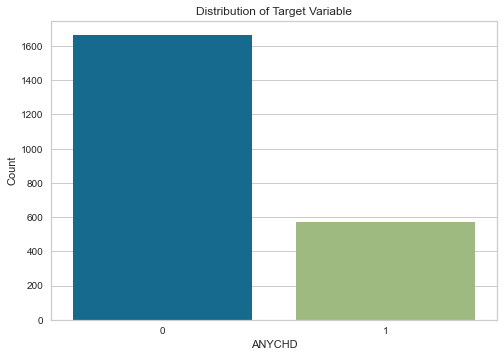

In [11]:
#distribution of the target variable
sns.countplot(x='ANYCHD', data=df)
plt.xlabel('ANYCHD')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

In [12]:
# Dealing with inbalanced dataset

# Separate the majority and minority classes
df_majority = df[df['ANYCHD'] == 0]
df_minority = df[df['ANYCHD'] == 1]

# Perform under-sampling
df_majority_resampled_under = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_resampled_under = pd.concat([df_majority_resampled_under, df_minority])

# Perform over-sampling
df_minority_resampled_over = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_resampled_over = pd.concat([df_majority, df_minority_resampled_over])

#class distribution before and after resampling
print("Original class distribution:\n", df['ANYCHD'].value_counts())
print("Class distribution after under-sampling:\n", df_resampled_under['ANYCHD'].value_counts())
print("Class distribution after over-sampling:\n", df_resampled_over['ANYCHD'].value_counts())


Original class distribution:
 0    1663
1     573
Name: ANYCHD, dtype: int64
Class distribution after under-sampling:
 0    573
1    573
Name: ANYCHD, dtype: int64
Class distribution after over-sampling:
 0    1663
1    1663
Name: ANYCHD, dtype: int64


In [13]:
df_resampled_over.isnull().sum()

SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVHYP     0
HDLC        0
LDLC        0
ANYCHD      0
dtype: int64

In [14]:
#testing the rearranging worked
print('\nColumn Name:', 'ANYCHD',)
print(df_resampled_over['ANYCHD'].value_counts())


Column Name: ANYCHD
0    1663
1    1663
Name: ANYCHD, dtype: int64


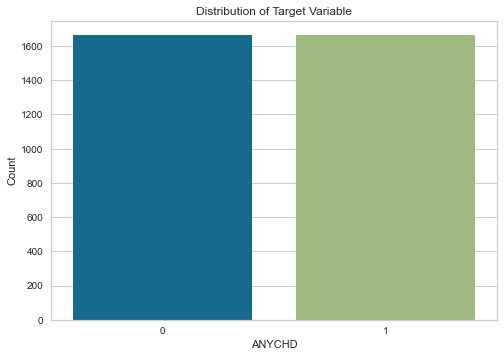

In [15]:
#distribution of the target variable
sns.countplot(x='ANYCHD', data=df_resampled_over)
plt.xlabel('ANYCHD')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

In [16]:
#shuffling the data
shuffled_df = df_resampled_over.sample(frac=1.0, random_state=42)
shuffled_df.head()

SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
587     2    240.0   58  166.0   90.0        0  28.78         0     1.0   
31      2    180.0   52  195.0  107.0        2  22.36         0     1.0   
854     1    330.0   50  131.0   83.0        1  26.20         0     0.0   
363     2    198.0   47  135.0   73.0        3  20.81         0     0.0   
1869    2    145.0   51  122.0   80.0        0  32.91         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  ANYCHD  
587       76.0     76.0   3.0        1  74.0  157.0       0  
31        68.0     75.0   4.0        1  60.0  120.0       1  
854       75.0     87.0   1.0        0  34.0  296.0       1  
363       69.0     98.0   2.0        1  28.0  170.0       1  
1869      78.0     79.0   2.0        0  32.0  113.0       0

In [17]:
shuffled_df.isnull().sum()

SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVHYP     0
HDLC        0
LDLC        0
ANYCHD      0
dtype: int64

#### Visualizing Data

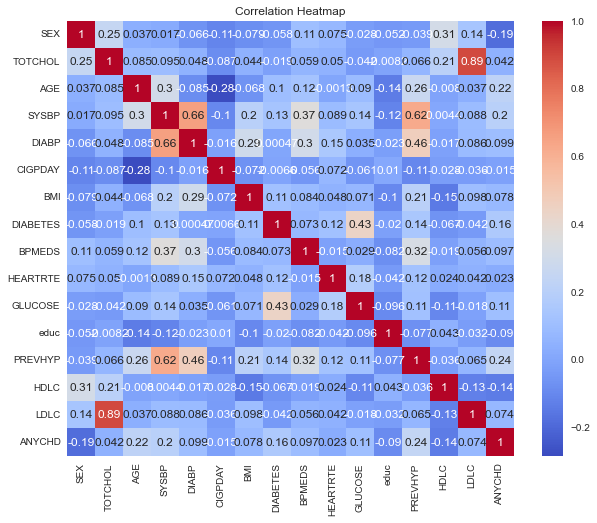

In [18]:
# correlation matrix
correlation_matrix = shuffled_df.corr()

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
shuffled_df.corr()

SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY  \
SEX       1.000000  0.248731  0.036937  0.017323 -0.065973 -0.109399   
TOTCHOL   0.248731  1.000000  0.084922  0.095051  0.048117 -0.086873   
AGE       0.036937  0.084922  1.000000  0.301849 -0.085153 -0.283813   
SYSBP     0.017323  0.095051  0.301849  1.000000  0.658072 -0.099920   
DIABP    -0.065973  0.048117 -0.085153  0.658072  1.000000 -0.016163   
CIGPDAY  -0.109399 -0.086873 -0.283813 -0.099920 -0.016163  1.000000   
BMI      -0.078784  0.043750 -0.067926  0.202020  0.290388 -0.072209   
DIABETES -0.058174 -0.018812  0.099591  0.132140  0.000472 -0.006604   
BPMEDS    0.105052  0.058502  0.123020  0.366290  0.299358 -0.055799   
HEARTRTE  0.074826  0.049627 -0.001291  0.088864  0.147833  0.072241   
GLUCOSE  -0.028455 -0.041600  0.089856  0.135165  0.035485 -0.061074   
educ     -0.051796 -0.008225 -0.140236 -0.116386 -0.023317  0.010385   
PREVHYP  -0.039499  0.066236  0.264773  0.619388  0.464892 -0.105192   
HDLC      0.312429  0.206588 -0.008030  0.004354 -0.016795 -0.028401   
LDLC      0.136446  0.892831  0.036935  0.088461  0.086281 -0.035539   
ANYCHD   -0.188372  0.042278  0.219232  0.201755  0.099126 -0.015154   

               BMI  DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ  \
SEX      -0.078784 -0.058174  0.105052  0.074826 -0.028455 -0.051796   
TOTCHOL   0.043750 -0.018812  0.058502  0.049627 -0.041600 -0.008225   
AGE      -0.067926  0.099591  0.123020 -0.001291  0.089856 -0.140236   
SYSBP     0.202020  0.132140  0.366290  0.088864  0.135165 -0.116386   
DIABP     0.290388  0.000472  0.299358  0.147833  0.035485 -0.023317   
CIGPDAY  -0.072209 -0.006604 -0.055799  0.072241 -0.061074  0.010385   
BMI       1.000000  0.114497  0.083618  0.047547  0.071181 -0.102509   
DIABETES  0.114497  1.000000  0.072845  0.115658  0.433926 -0.020462   
BPMEDS    0.083618  0.072845  1.000000 -0.015237  0.028877 -0.082014   
HEARTRTE  0.047547  0.115658 -0.015237  1.000000  0.180856 -0.041680   
GLUCOSE   0.071181  0.433926  0.028877  0.180856  1.000000 -0.095635   
educ     -0.102509 -0.020462 -0.082014 -0.041680 -0.095635  1.000000   
PREVHYP   0.205157  0.142715  0.324081  0.118338  0.113819 -0.076676   
HDLC     -0.145765 -0.066713 -0.019234  0.024485 -0.105781  0.042814   
LDLC      0.097934 -0.041701  0.056038  0.042174 -0.017526 -0.031614   
ANYCHD    0.077852  0.160649  0.096639  0.022615  0.107078 -0.089874   

           PREVHYP      HDLC      LDLC    ANYCHD  
SEX      -0.039499  0.312429  0.136446 -0.188372  
TOTCHOL   0.066236  0.206588  0.892831  0.042278  
AGE       0.264773 -0.008030  0.036935  0.219232  
SYSBP     0.619388  0.004354  0.088461  0.201755  
DIABP     0.464892 -0.016795  0.086281  0.099126  
CIGPDAY  -0.105192 -0.028401 -0.035539 -0.015154  
BMI       0.205157 -0.145765  0.097934  0.077852  
DIABETES  0.142715 -0.066713 -0.041701  0.160649  
BPMEDS    0.324081 -0.019234  0.056038  0.096639  
HEARTRTE  0.118338  0.024485  0.042174  0.022615  
GLUCOSE   0.113819 -0.105781 -0.017526  0.107078  
educ     -0.076676  0.042814 -0.031614 -0.089874  
PREVHYP   1.000000 -0.036403  0.064589  0.239471  
HDLC     -0.036403  1.000000 -0.126274 -0.138398  
LDLC      0.064589 -0.126274  1.000000  0.073684  
ANYCHD    0.239471 -0.138398  0.073684  1.000000

In [20]:
#Variable Correlations with the target "Quality"
shuffled_df.corr()['ANYCHD'].sort_values(ascending=False)

ANYCHD      1.000000
PREVHYP     0.239471
AGE         0.219232
SYSBP       0.201755
DIABETES    0.160649
GLUCOSE     0.107078
DIABP       0.099126
BPMEDS      0.096639
BMI         0.077852
LDLC        0.073684
TOTCHOL     0.042278
HEARTRTE    0.022615
CIGPDAY    -0.015154
educ       -0.089874
HDLC       -0.138398
SEX        -0.188372
Name: ANYCHD, dtype: float64

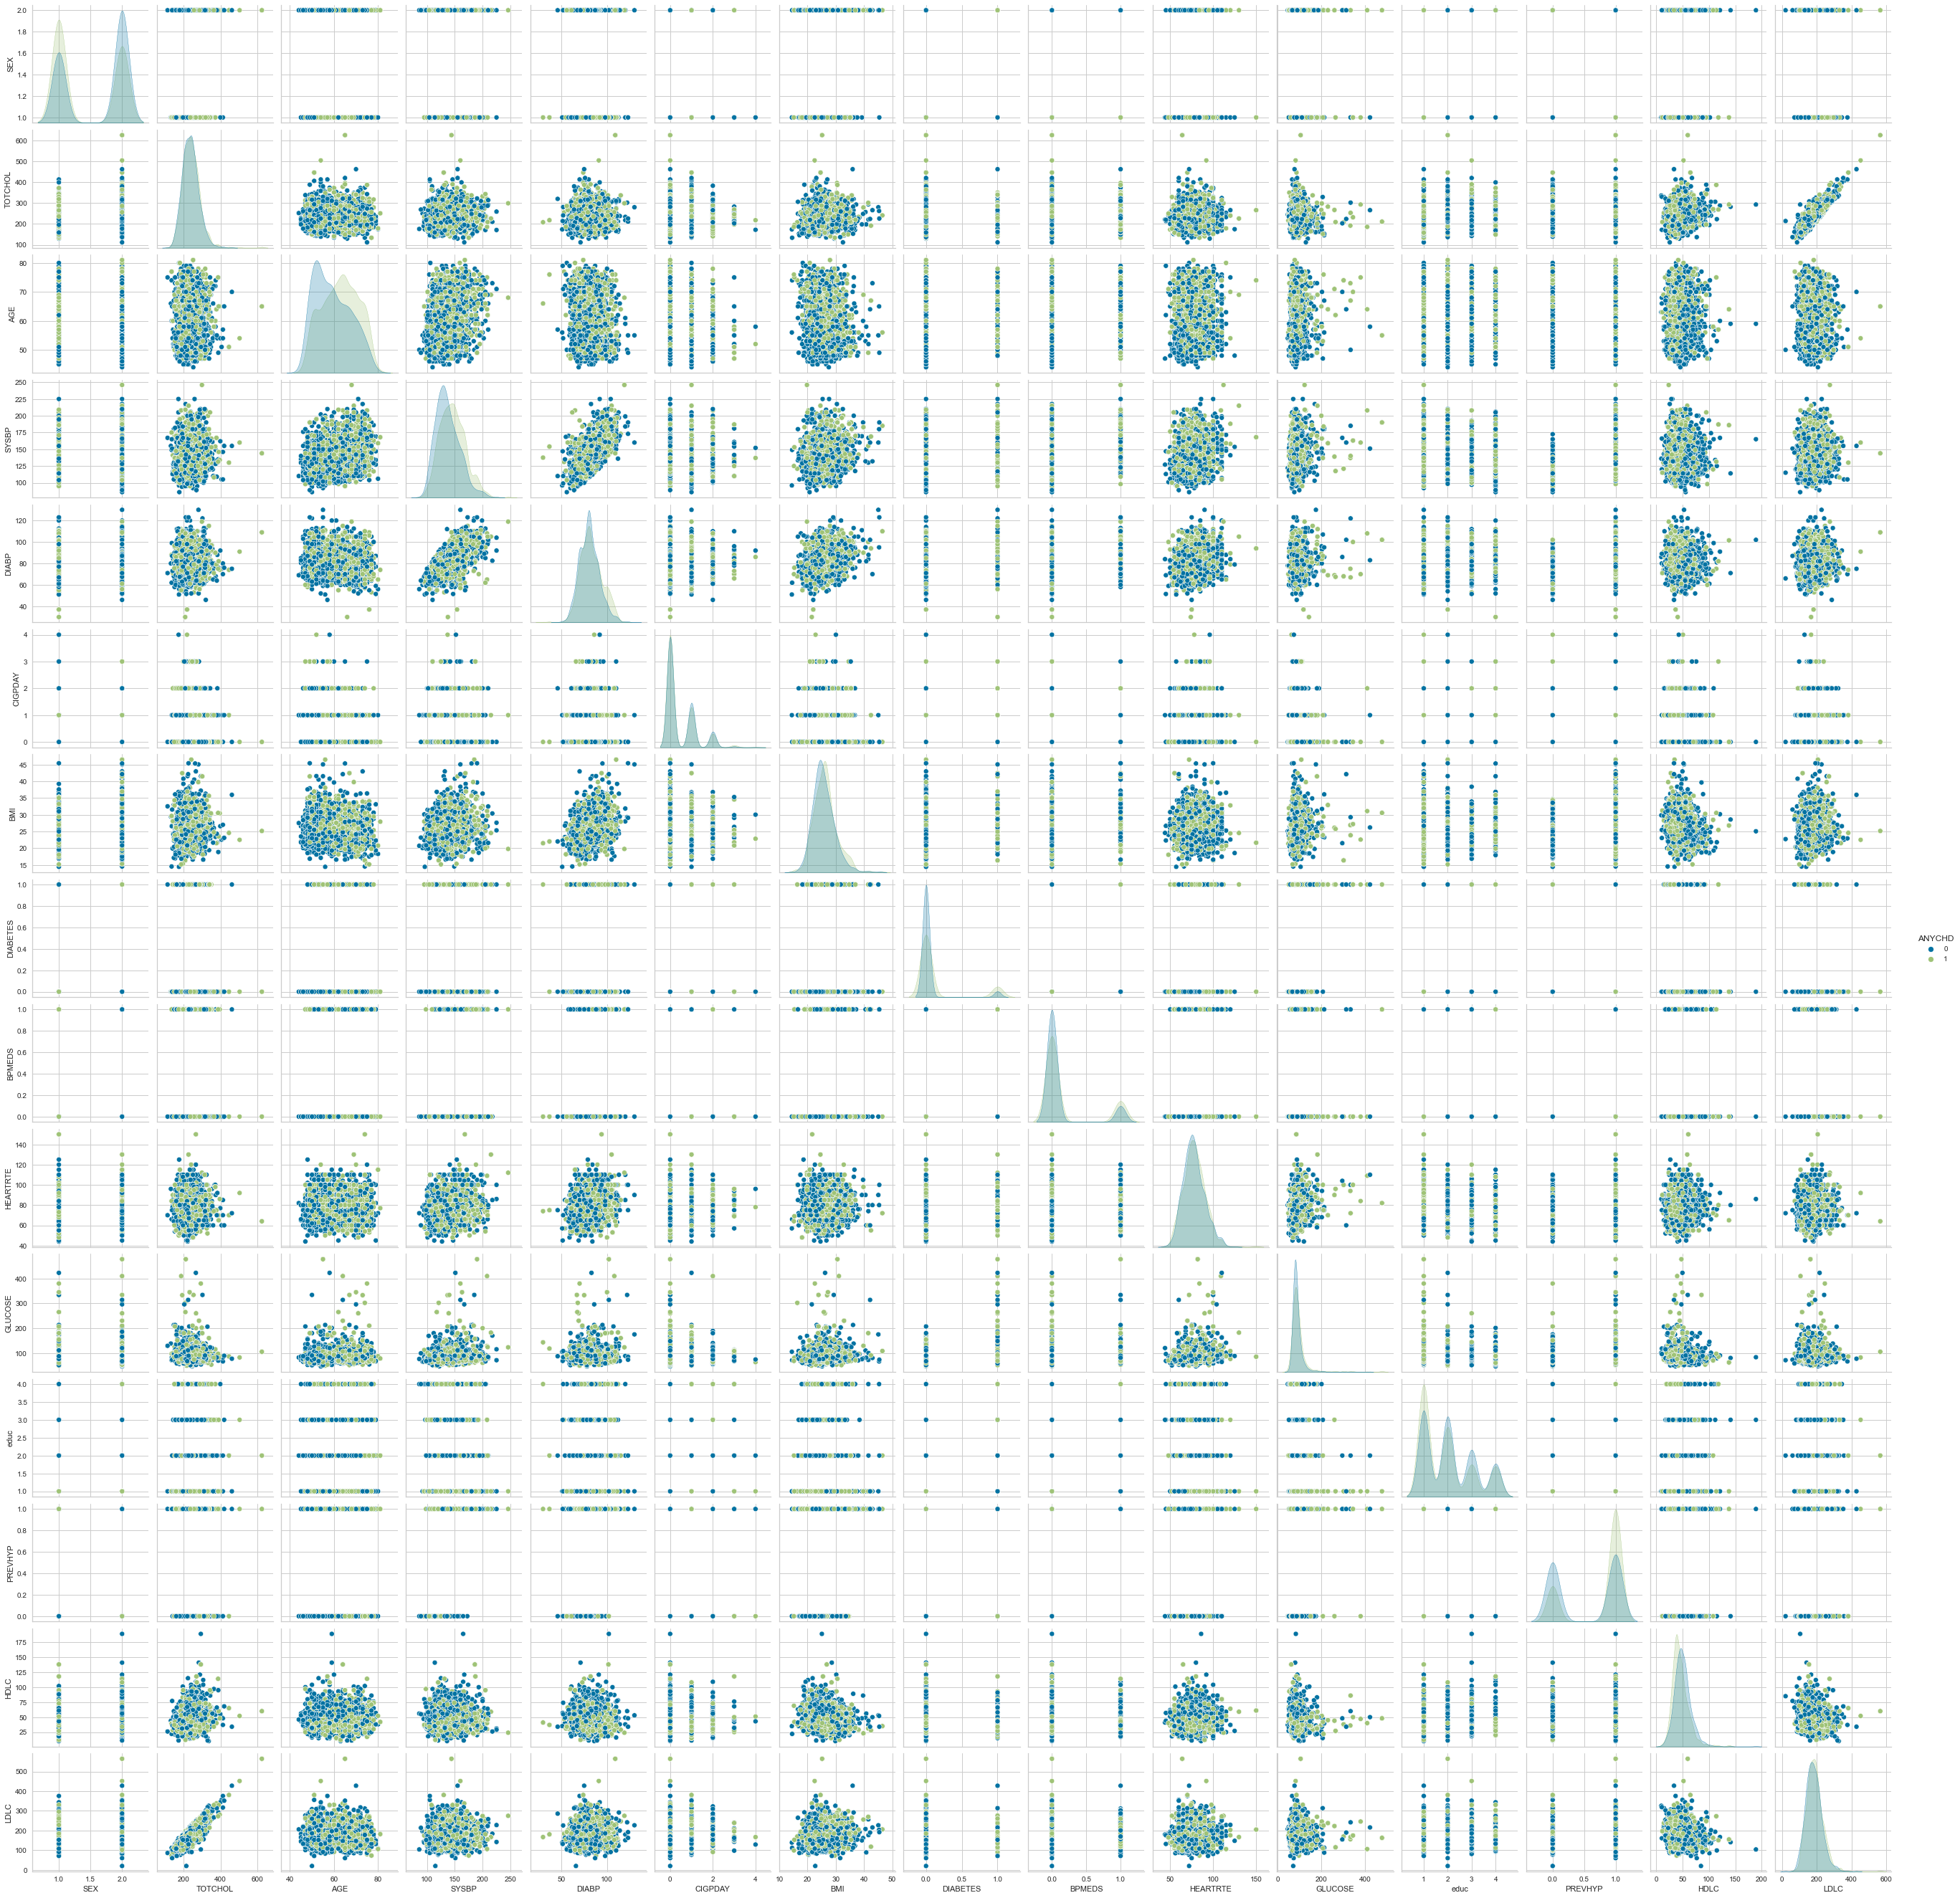

In [21]:
#using seaborn to create a pairplot to help analyze the data

sns.pairplot(shuffled_df, hue='ANYCHD')

#### Splitting Data

In [22]:
#splitting into target and data set
y = shuffled_df["ANYCHD"]
X = shuffled_df.drop(['ANYCHD'],axis=1)
print(X.shape)
X.head()

(3326, 15)


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
587     2    240.0   58  166.0   90.0        0  28.78         0     1.0   
31      2    180.0   52  195.0  107.0        2  22.36         0     1.0   
854     1    330.0   50  131.0   83.0        1  26.20         0     0.0   
363     2    198.0   47  135.0   73.0        3  20.81         0     0.0   
1869    2    145.0   51  122.0   80.0        0  32.91         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  
587       76.0     76.0   3.0        1  74.0  157.0  
31        68.0     75.0   4.0        1  60.0  120.0  
854       75.0     87.0   1.0        0  34.0  296.0  
363       69.0     98.0   2.0        1  28.0  170.0  
1869      78.0     79.0   2.0        0  32.0  113.0

In [23]:
shuffled_df.isnull().sum()

SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVHYP     0
HDLC        0
LDLC        0
ANYCHD      0
dtype: int64

In [24]:
shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3326 entries, 587 to 1312
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       3326 non-null   int64  
 1   TOTCHOL   3326 non-null   float64
 2   AGE       3326 non-null   int64  
 3   SYSBP     3326 non-null   float64
 4   DIABP     3326 non-null   float64
 5   CIGPDAY   3326 non-null   int64  
 6   BMI       3326 non-null   float64
 7   DIABETES  3326 non-null   int64  
 8   BPMEDS    3326 non-null   float64
 9   HEARTRTE  3326 non-null   float64
 10  GLUCOSE   3326 non-null   float64
 11  educ      3326 non-null   float64
 12  PREVHYP   3326 non-null   int64  
 13  HDLC      3326 non-null   float64
 14  LDLC      3326 non-null   float64
 15  ANYCHD    3326 non-null   int64  
dtypes: float64(10), int64(6)
memory usage: 441.7 KB


In [25]:
#data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2660, 15)
y_train shape: (2660,)
X_test shape: (666, 15)
y_test shape: (666,)


## Model Selection

### Logistic Regression

### kaggle

In [27]:
#logistic regression 
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[232 116]
 [ 97 221]]


Accuracy of Logistic Regression: 68.01801801801803 

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       348
           1       0.66      0.69      0.67       318

    accuracy                           0.68       666
   macro avg       0.68      0.68      0.68       666
weighted avg       0.68      0.68      0.68       666



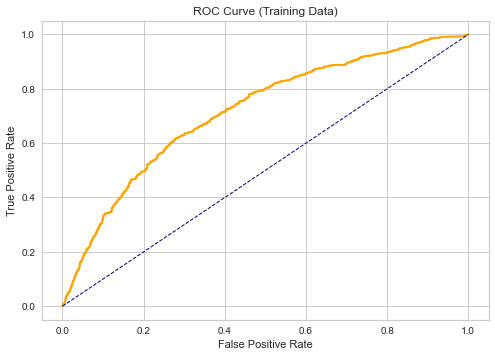

In [28]:
#Using a cross validation to predict the probabilities of the training data
lr_proba_cv = cross_val_predict(lr, X_train, y_train,method='predict_proba', cv=5)

#Choosing the second column containing the predicted probabilities
y_train_cv_score_lr = lr_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_score_lr)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [29]:

#Area under ROC curve
roc_auc_score(y_train, y_train_cv_score_lr)

0.7161717104612211

### other

In [30]:
%%time

warnings.filterwarnings('ignore')

# Logistic Regression model
log_reg = LogisticRegression()
hyperparameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100,250 ,500, 1000],
    'tol': [1e-6, 1e-5, 1e-4, 1e-3],
    'class_weight': [None, 'balanced']
}
grid_log_reg = GridSearchCV(log_reg, hyperparameters, cv=5, n_jobs=-1)
grid_log_reg.fit(X_train, y_train)
best_params_log_reg=grid_log_reg.best_params_
print("Best Logistic Regression parameters:", grid_log_reg.best_params_)
print("Best Logistic Regression score:", grid_log_reg.best_score_)

/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not conver

/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/envs/MLClassEnv_10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm di

Best Logistic Regression parameters: {'C': 0.01, 'class_weight': None, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-06}
Best Logistic Regression score: 0.6672932330827067
CPU times: user 3.8 s, sys: 341 ms, total: 4.14 s
Wall time: 17.1 s


In [31]:
best_log_reg = LogisticRegression(**best_params_log_reg)
best_log_reg.fit(X_train, y_train)
y_predicted = best_log_reg.predict(X_test)

best_log_reg_conf_matrix = confusion_matrix(y_test, y_predicted)
best_log_reg_acc_score = accuracy_score(y_test, y_predicted)
print("confussion matrix")
print(best_log_reg_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",best_log_reg_acc_score*100,'\n')
print(classification_report(y_test,y_predicted))

confussion matrix
[[233 115]
 [101 217]]


Accuracy of Logistic Regression: 67.56756756756756 

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       348
           1       0.65      0.68      0.67       318

    accuracy                           0.68       666
   macro avg       0.68      0.68      0.68       666
weighted avg       0.68      0.68      0.68       666



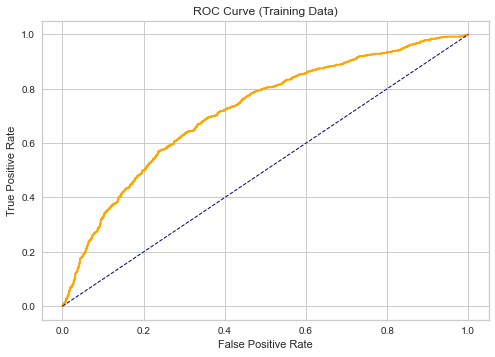

In [32]:
#Using a cross validation to predict the probabilities of the training data
best_log_reg_proba_cv = cross_val_predict(best_log_reg, X_train, y_train,method='predict_proba', cv=5)

#Choosing the second column containing the predicted probabilities
y_train_cv_score_best_log_reg = best_log_reg_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_score_best_log_reg)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [33]:
#Area under ROC curve
roc_auc_score(y_train, y_train_cv_score_best_log_reg)

0.7179470507583361

In [34]:
best_log_reg.fit(X_train, y_train)

train_score = best_log_reg.score(X_train, y_train)
test_score = best_log_reg.score(X_test, y_test)

cv_scores = cross_val_score(best_log_reg, X, y, cv=5)  # 5-fold cross-validation
mean_cv_score = cv_scores.mean()

print("Training score:", train_score)
print("Test score:", test_score)
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", mean_cv_score)

Training score: 0.6691729323308271
Test score: 0.6756756756756757
Cross-validated scores: [0.66216216 0.65714286 0.66766917 0.64511278 0.66015038]
Mean cross-validated score: 0.6584474700264173


In [35]:
## Notice that the logistic regression with default values gives slightly better performance
###May be worth investigating further
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

cv_scores = cross_val_score(lr, X, y, cv=5)  # 5-fold cross-validation
mean_cv_score = cv_scores.mean()

print("Training score:", train_score)
print("Test score:", test_score)
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", mean_cv_score)

Training score: 0.6661654135338346
Test score: 0.6801801801801802
Cross-validated scores: [0.63813814 0.64210526 0.65263158 0.65263158 0.6481203 ]
Mean cross-validated score: 0.64672537198853


### Naive Bayes

In [36]:
from sklearn.preprocessing import MinMaxScaler
#nomalizing data for the multinomial distribution as it does not take negatives
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [37]:
models = {'GaussianNB': GaussianNB(),
          'MultinomialNB':MultinomialNB(),
          'BernoulliNB': BernoulliNB()}
best_nb_model = None
best_nb_score = 0
for name, model in models.items():
    score = np.mean(cross_val_score(model, X_train_normalized, y_train, cv=5))
    if score > best_nb_score:
        best_nb_score = score
        best_nb_model = name
print("Best Naive Bayes model:", best_nb_model)

Best Naive Bayes model: MultinomialNB


In [38]:
hyperparameters = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()

grid_gnb = GridSearchCV(gnb, hyperparameters, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_gnb.fit(X_train, y_train)

best_params_gnb = grid_gnb.best_params_

print("Best Naive Bayes  parameters:", best_params_gnb)
print("Best Naive Bayes score (accuracy):", grid_gnb.best_score_)
print("\n")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Naive Bayes  parameters: {'var_smoothing': 0.23101297000831597}
Best Naive Bayes score (accuracy): 0.6248120300751879




In [39]:
best_gnb = GaussianNB(**best_params_gnb)
best_gnb.fit(X_train, y_train)
y_predicted_gnb = best_gnb.predict(X_test)

best_gnb_conf_matrix = confusion_matrix(y_test, y_predicted_gnb)
best_gnb_acc_score = accuracy_score(y_test, y_predicted_gnb)
print("confussion matrix")
print(best_gnb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes:",best_gnb_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_gnb))

confussion matrix
[[286  62]
 [176 142]]


Accuracy of Naive Bayes: 64.26426426426426 

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       348
           1       0.70      0.45      0.54       318

    accuracy                           0.64       666
   macro avg       0.66      0.63      0.63       666
weighted avg       0.66      0.64      0.63       666



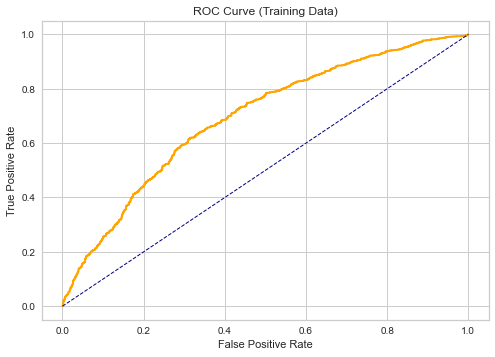

In [40]:
#Using a cross validation to predict the probabilities of the training data
best_gnb_proba_cv = cross_val_predict(best_gnb, X_train, y_train,method='predict_proba', cv=5)

#Choosing the second column containing the predicted probabilities
y_train_cv_score_best_gnb = best_gnb_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_score_best_gnb)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [41]:
#Area under ROC curve
roc_auc_score(y_train, y_train_cv_score_best_gnb)

0.6920383903204376

In [42]:
best_gnb.fit(X_train, y_train)

gnb_train_score = best_gnb.score(X_train, y_train)
gnb_test_score = best_gnb.score(X_test, y_test)
gnb_cv_scores = cross_val_score(best_gnb, X, y, cv=5)  # 5-fold cross-validation
gnb_mean_cv_score = gnb_cv_scores.mean()

print("Training score:", gnb_train_score)
print("Test score:", gnb_test_score)
print("Cross-validated scores:", gnb_cv_scores)
print("Mean cross-validated score:", gnb_mean_cv_score)

Training score: 0.6278195488721805
Test score: 0.6426426426426426
Cross-validated scores: [0.54804805 0.55789474 0.56842105 0.56390977 0.53984962]
Mean cross-validated score: 0.5556246472035946


## SVM

In [43]:
%%time
warnings.filterwarnings('ignore')

# Support Vector Machines model
hyperparameters = {'C': [0.001,0.01,0.1, 1,10, 100],
'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
'gamma': ['scale', 'auto']}
svm=SVC()
grid_svm = GridSearchCV(svm, hyperparameters, cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_params_svm=grid_svm.best_params_
print("Best SVM parameters:", grid_svm.best_params_)
print("Best SVM score:", grid_svm.best_score_)

Best SVM parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM score: 0.7947368421052632
CPU times: user 923 ms, sys: 53.8 ms, total: 977 ms
Wall time: 13.9 s


In [44]:
#testing model with optimal parameters
best_svm = SVC(**best_params_svm,probability=True)

#Testing smaller values of C||did not work. performing worse
#best_svm = SVC(C=0.001,kernel='sigmoid',gamma='scale',probability=True)
best_svm.fit(X_train, y_train)
y_predicted_svm = best_svm.predict(X_test)

best_svm_conf_matrix = confusion_matrix(y_test, y_predicted_svm)
best_svm_acc_score = accuracy_score(y_test, y_predicted_svm)
print("confussion matrix")
print(best_svm_conf_matrix)
print("\n")
print("Accuracy of SVM:",best_svm_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_svm))

confussion matrix
[[260  88]
 [ 24 294]]


Accuracy of SVM: 83.18318318318319 

              precision    recall  f1-score   support

           0       0.92      0.75      0.82       348
           1       0.77      0.92      0.84       318

    accuracy                           0.83       666
   macro avg       0.84      0.84      0.83       666
weighted avg       0.85      0.83      0.83       666



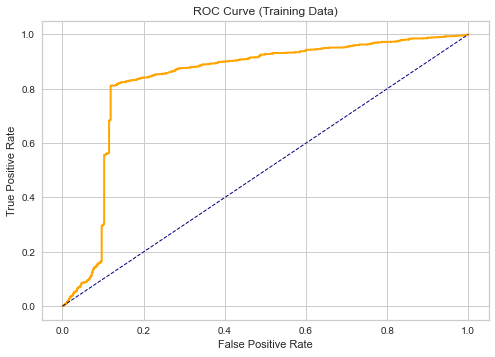

In [45]:
#Using a cross validation to predict the probabilities of the training data
best_svm_proba_cv = cross_val_predict(best_svm, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_svm = best_svm_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_svm)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [46]:
### Area under ROC curve
##
##notice the y_train_cv_proba_best_svm name proba
##
roc_auc_score(y_train, y_train_cv_proba_best_svm)

0.8338592449149789

In [47]:
best_svm.fit(X_train, y_train)

svm_train_score = best_svm.score(X_train, y_train)
svm_test_score = best_svm.score(X_test, y_test)
svm_cv_scores = cross_val_score(best_svm, X, y, cv=5)  # 5-fold cross-validation
svm_mean_cv_score = svm_cv_scores.mean()

print("Training score:", svm_train_score)
print("Test score:", svm_test_score)
print("Cross-validated scores:", svm_cv_scores)
print("Mean cross-validated score:", svm_mean_cv_score)

Training score: 0.9815789473684211
Test score: 0.8318318318318318
Cross-validated scores: [0.62162162 0.68270677 0.68721805 0.65263158 0.67669173]
Mean cross-validated score: 0.6641739483844746


## Decision Tree

In [48]:
%%time
warnings.filterwarnings('ignore')
#Decision Tree Model
dtc=DecisionTreeClassifier()
hyperparameters ={
    "max_depth": [2, 4, 6, 8, 10, None],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10, 15],
    "max_features": [int, float, "sqrt", "log2", None],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_leaf_nodes": [None, 5, 10, 15, 20],
    "min_impurity_decrease": [0.0, 0.1, 0.2, 0.3, 0.4]
}
grid_dtc = GridSearchCV(dtc, hyperparameters, cv=5, n_jobs=-1)
grid_dtc.fit(X_train, y_train)
best_params_dtc=grid_dtc.best_params_
print("Best Decision Tree parameters:", grid_dtc.best_params_)
print("Best Decision Tree score:", grid_dtc.best_score_)

Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Decision Tree score: 0.8263157894736842
CPU times: user 26.5 s, sys: 1.05 s, total: 27.5 s
Wall time: 1min 1s


In [49]:
#testing model with optimal parameters
best_dtc = DecisionTreeClassifier(**best_params_dtc)

best_dtc.fit(X_train, y_train)
y_predicted_dtc = best_dtc.predict(X_test)

best_dtc_conf_matrix = confusion_matrix(y_test, y_predicted_dtc)
best_dtc_acc_score = accuracy_score(y_test, y_predicted_dtc)
print("confussion matrix")
print(best_dtc_conf_matrix)
print("\n")
print("Accuracy of Decision Tree Clasifier:",best_dtc_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_dtc))


tn, fp, fn, tp = best_dtc_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")


confussion matrix
[[264  84]
 [ 15 303]]


Accuracy of Decision Tree Clasifier: 85.13513513513513 

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       348
           1       0.78      0.95      0.86       318

    accuracy                           0.85       666
   macro avg       0.86      0.86      0.85       666
weighted avg       0.87      0.85      0.85       666

Confusion Matrix:
      Predicted
       +   -
True  + 303 15
      - 84 264


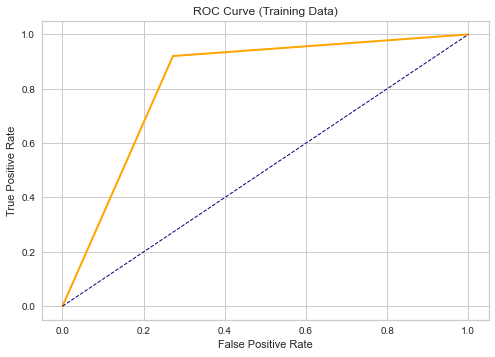

In [50]:
#Using a cross validation to predict the probabilities of the training data
best_dtc_proba_cv = cross_val_predict(best_dtc, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_dtc = best_dtc_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_dtc)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [51]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_dtc)

0.8241013753233353

In [52]:
best_dtc.fit(X_train, y_train)
dtc_train_score = best_dtc.score(X_train, y_train)
dtc_test_score = best_dtc.score(X_test, y_test)
dtc_cv_scores = cross_val_score(best_dtc, X, y, cv=5)  # 5-fold cross-validation
dtc_mean_cv_score = dtc_cv_scores.mean()

print("Training score:", dtc_train_score)
print("Test score:", dtc_test_score)
print("Cross-validated scores:", dtc_cv_scores)
print("Mean cross-validated score:", dtc_mean_cv_score)

Training score: 1.0
Test score: 0.8438438438438438
Cross-validated scores: [0.86786787 0.82706767 0.81353383 0.84210526 0.84360902]
Mean cross-validated score: 0.8388367314683105


## KNN

In [53]:
%%time
warnings.filterwarnings('ignore')

# KNN Model
knn = KNeighborsClassifier()
hyperparameters = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}
grid_knn = GridSearchCV(knn, hyperparameters, cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_params_knn=grid_knn.best_params_
print("Best KNN parameters:", grid_knn.best_params_)
print("Best KNN score:", grid_knn.best_score_)

Best KNN parameters: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best KNN score: 0.8278195488721805
CPU times: user 586 ms, sys: 99.9 ms, total: 686 ms
Wall time: 3.88 s


In [54]:
#testing model with optimal parameters
best_knn = KNeighborsClassifier(**best_params_knn)

best_knn.fit(X_train, y_train)
y_predicted_knn = best_knn.predict(X_test)

best_knn_conf_matrix = confusion_matrix(y_test, y_predicted_knn)
best_knn_acc_score = accuracy_score(y_test, y_predicted_knn)
print("confussion matrix")
print(best_knn_conf_matrix)
print("\n")
print("Accuracy of KNN Clasifier:",best_knn_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_knn))


tn, fp, fn, tp = best_knn_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")

confussion matrix
[[264  84]
 [ 15 303]]


Accuracy of KNN Clasifier: 85.13513513513513 

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       348
           1       0.78      0.95      0.86       318

    accuracy                           0.85       666
   macro avg       0.86      0.86      0.85       666
weighted avg       0.87      0.85      0.85       666

Confusion Matrix:
      Predicted
       +   -
True  + 303 15
      - 84 264


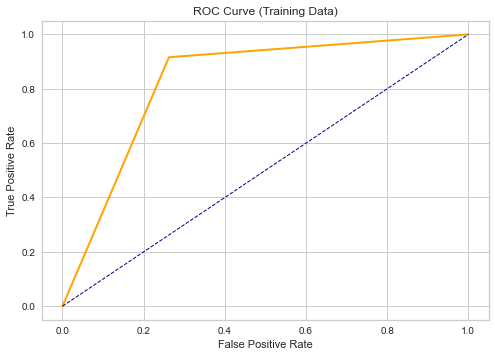

In [55]:
#Using a cross validation to predict the probabilities of the training data
best_knn_proba_cv = cross_val_predict(best_knn, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_knn = best_knn_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_knn)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [56]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_knn)

0.8268138578314275

In [57]:
best_knn.fit(X_train, y_train)
knn_train_score = best_knn.score(X_train, y_train)
knn_test_score = best_knn.score(X_test, y_test)
knn_cv_scores = cross_val_score(best_knn, X, y, cv=5)  # 5-fold cross-validation
knn_mean_cv_score = knn_cv_scores.mean()

print("Training score:", knn_train_score)
print("Test score:", knn_test_score)
print("Cross-validated scores:", knn_cv_scores)
print("Mean cross-validated score:", knn_mean_cv_score)

Training score: 1.0
Test score: 0.8513513513513513
Cross-validated scores: [0.85735736 0.85413534 0.85413534 0.83909774 0.8556391 ]
Mean cross-validated score: 0.85207297523087


### Evaluating Models

In [58]:
print("Accuracy of Logistic Regression:",best_log_reg_acc_score*100,'\n')
print(classification_report(y_test,y_predicted))

Accuracy of Logistic Regression: 67.56756756756756 

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       348
           1       0.65      0.68      0.67       318

    accuracy                           0.68       666
   macro avg       0.68      0.68      0.68       666
weighted avg       0.68      0.68      0.68       666



In [59]:
print("Accuracy of Naive Bayes:",best_gnb_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_gnb))

Accuracy of Naive Bayes: 64.26426426426426 

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       348
           1       0.70      0.45      0.54       318

    accuracy                           0.64       666
   macro avg       0.66      0.63      0.63       666
weighted avg       0.66      0.64      0.63       666



In [60]:
print("Accuracy of Support Vector Machines:",best_svm_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_svm))

Accuracy of Support Vector Machines: 83.18318318318319 

              precision    recall  f1-score   support

           0       0.92      0.75      0.82       348
           1       0.77      0.92      0.84       318

    accuracy                           0.83       666
   macro avg       0.84      0.84      0.83       666
weighted avg       0.85      0.83      0.83       666



In [61]:
print("Accuracy of Decision Tree:",best_dtc_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_dtc))

Accuracy of Decision Tree: 85.13513513513513 

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       348
           1       0.78      0.95      0.86       318

    accuracy                           0.85       666
   macro avg       0.86      0.86      0.85       666
weighted avg       0.87      0.85      0.85       666



In [62]:
print("Accuracy of KNN:",best_knn_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_knn))

Accuracy of KNN: 85.13513513513513 

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       348
           1       0.78      0.95      0.86       318

    accuracy                           0.85       666
   macro avg       0.86      0.86      0.85       666
weighted avg       0.87      0.85      0.85       666



### Ensemble Models

#### Stacking Ensemble Model

In [63]:
#taking top three models from above
estimators = [
('svm', grid_svm.best_estimator_),
('dtc', grid_dtc.best_estimator_),
('knn', grid_knn.best_estimator_),  
]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_classifier.fit(X_train, y_train)
y_predicted_stacking=stacking_classifier.predict(X_test)


best_stacking_conf_matrix = confusion_matrix(y_test, y_predicted_stacking)
best_stacking_acc_score = accuracy_score(y_test, y_predicted_stacking)
print("confussion matrix")
print(best_stacking_conf_matrix)
print("\n")
print("Accuracy of Stacking Clasifier:",best_stacking_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_stacking))


tn, fp, fn, tp = best_knn_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")



confussion matrix
[[316  32]
 [ 18 300]]


Accuracy of Stacking Clasifier: 92.49249249249249 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       348
           1       0.90      0.94      0.92       318

    accuracy                           0.92       666
   macro avg       0.92      0.93      0.92       666
weighted avg       0.93      0.92      0.92       666

Confusion Matrix:
      Predicted
       +   -
True  + 303 15
      - 84 264


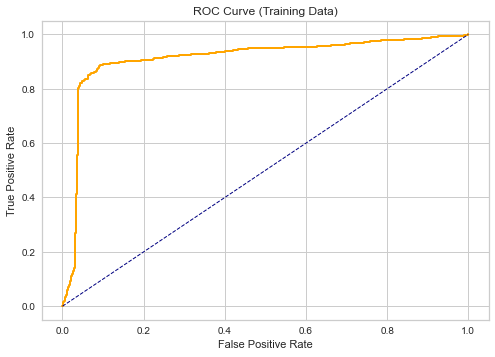

In [64]:
#Using a cross validation to predict the probabilities of the training data
best_stacking_proba_cv = cross_val_predict(stacking_classifier, X_train, y_train,method='predict_proba', cv=5)

#Choosing the second column containing the predicted probabilities
y_train_cv_proba_best_stacking = best_stacking_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_stacking)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [65]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_stacking)

0.9124649808472444

In [66]:
stacking_classifier.fit(X_train, y_train)
stacking_train_score = stacking_classifier.score(X_train, y_train)
stacking_test_score = stacking_classifier.score(X_test, y_test)
stacking_cv_scores = cross_val_score(stacking_classifier, X, y, cv=5)  # 5-fold cross-validation
stacking_mean_cv_score = stacking_cv_scores.mean()

print("Training score:", stacking_train_score)
print("Test score:", stacking_test_score)
print("Cross-validated scores:", stacking_cv_scores)
print("Mean cross-validated score:", stacking_mean_cv_score)

Training score: 1.0
Test score: 0.9279279279279279
Cross-validated scores: [0.90990991 0.91879699 0.90827068 0.90075188 0.92030075]
Mean cross-validated score: 0.911606042132358


#### XGBoost

##### No need tuning takes a long time. best_params_xgb has the best parameters

In [67]:
# %%time
# warnings.filterwarnings('ignore')

# # XGBoost Model
# xgb = XGBClassifier()
# hyperparameters= {
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 5, 7, 10],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#     'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
# }


# grid_xgb = RandomizedSearchCV(xgb, hyperparameters, cv=5, n_jobs=-1,n_iter=5000)

# grid_xgb.fit(X_train, y_train)
# best_params_xgb=grid_xgb.best_params_
# print("Best XGB parameters:", grid_xgb.best_params_)
# print("Best XGB score:", grid_xgb.best_score_)

In [68]:
best_params_xgb={'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 1.0, 'gamma': 0.3, 'colsample_bytree': 0.5, 'alpha': 0.5}
#testing model with optimal parameters
best_xgb = XGBClassifier(**best_params_xgb)

best_xgb.fit(X_train, y_train)
y_predicted_xgb = best_xgb.predict(X_test)

best_xgb_conf_matrix = confusion_matrix(y_test, y_predicted_xgb)
best_xgb_acc_score = accuracy_score(y_test, y_predicted_xgb)
print("confussion matrix")
print(best_xgb_conf_matrix)
print("\n")
print("Accuracy of XGB Clasifier:",best_xgb_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_xgb))


tn, fp, fn, tp = best_xgb_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")

confussion matrix
[[295  53]
 [ 16 302]]


Accuracy of XGB Clasifier: 89.63963963963964 

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       348
           1       0.85      0.95      0.90       318

    accuracy                           0.90       666
   macro avg       0.90      0.90      0.90       666
weighted avg       0.90      0.90      0.90       666

Confusion Matrix:
      Predicted
       +   -
True  + 302 16
      - 53 295


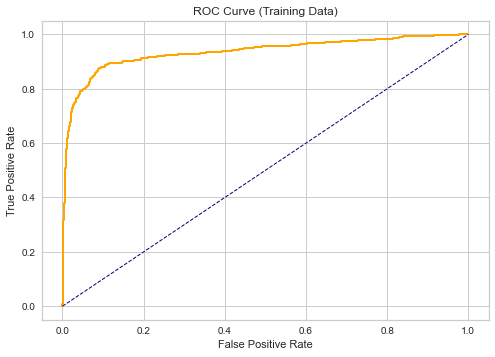

In [69]:
#Using a cross validation to predict the probabilities of the training data
best_xgb_proba_cv = cross_val_predict(best_xgb, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_xgb = best_xgb_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_xgb)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [70]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_xgb)

0.9347528517110266

In [71]:
best_xgb.fit(X_train, y_train)
xgb_train_score = best_xgb.score(X_train, y_train)
xgb_test_score = best_xgb.score(X_test, y_test)
xgb_cv_scores = cross_val_score(best_xgb, X, y, cv=5)  # 5-fold cross-validation
xgb_mean_cv_score = xgb_cv_scores.mean()

print("Training score:", xgb_train_score)
print("Test score:", xgb_test_score)
print("Cross-validated scores:", xgb_cv_scores)
print("Mean cross-validated score:", xgb_mean_cv_score)

Training score: 1.0
Test score: 0.8963963963963963
Cross-validated scores: [0.89189189 0.88421053 0.89323308 0.88421053 0.89774436]
Mean cross-validated score: 0.8902580776264987


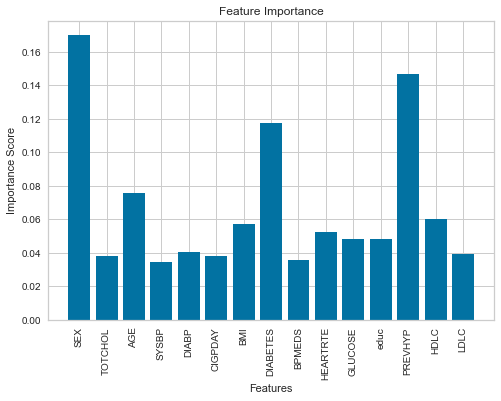

In [72]:
#feature importance
importance = best_xgb.feature_importances_
feature_names=X.columns
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.show()

#### Random Forest

##### No need tuning takes a long time. best_params_rf has the best parameters

In [73]:
# %%time
# warnings.filterwarnings('ignore')

# # Random Forest Model
# rf = RandomForestClassifier()
# hyperparameters= {
#  'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['log2', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]
# }


# grid_rf = RandomizedSearchCV(rf, hyperparameters, cv=5, n_jobs=-1,n_iter=500)

# grid_rf.fit(X_train, y_train)
# best_params_rf=grid_rf.best_params_
# print("Best Random Forest parameters:", grid_rf.best_params_)
# print("Best Random Forest score:", grid_rf.best_score_)

In [74]:
#best parameters: 
best_params_rf={'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
#testing model with optimal parameters
best_rf = RandomForestClassifier(**best_params_rf)

best_rf.fit(X_train, y_train)
y_predicted_rf = best_rf.predict(X_test)

best_rf_conf_matrix = confusion_matrix(y_test, y_predicted_rf)
best_rf_acc_score = accuracy_score(y_test, y_predicted_rf)
print("confussion matrix")
print(best_rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest Clasifier:",best_rf_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_rf))


tn, fp, fn, tp = best_rf_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")

confussion matrix
[[327  21]
 [ 17 301]]


Accuracy of Random Forest Clasifier: 94.29429429429429 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       348
           1       0.93      0.95      0.94       318

    accuracy                           0.94       666
   macro avg       0.94      0.94      0.94       666
weighted avg       0.94      0.94      0.94       666

Confusion Matrix:
      Predicted
       +   -
True  + 301 17
      - 21 327


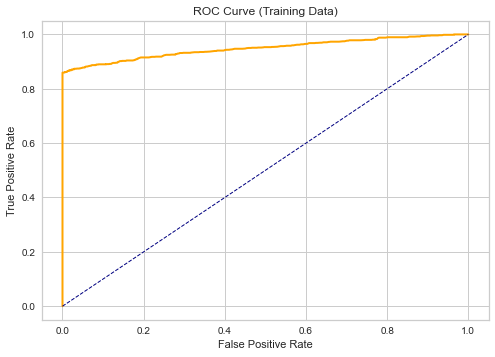

In [75]:
#Using a cross validation to predict the probabilities of the training data
best_rf_proba_cv = cross_val_predict(best_rf, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_rf = best_rf_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_rf)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [76]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_rf)

0.9485818479935544

In [77]:
best_rf.fit(X_train, y_train)
rf_train_score = best_rf.score(X_train, y_train)
rf_test_score = best_rf.score(X_test, y_test)
rf_cv_scores = cross_val_score(best_rf, X, y, cv=5)  # 5-fold cross-validation
rf_mean_cv_score = rf_cv_scores.mean()

print("Training score:", rf_train_score)
print("Test score:", rf_test_score)
print("Cross-validated scores:", rf_cv_scores)
print("Mean cross-validated score:", rf_mean_cv_score)

Training score: 1.0
Test score: 0.9429429429429429
Cross-validated scores: [0.91891892 0.92030075 0.93383459 0.90827068 0.93533835]
Mean cross-validated score: 0.923332655964235


#### Evaluating Ensemble Models

In [78]:
print("Accuracy of Stacking Clasifier:",best_stacking_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_stacking))

Accuracy of Stacking Clasifier: 92.49249249249249 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       348
           1       0.90      0.94      0.92       318

    accuracy                           0.92       666
   macro avg       0.92      0.93      0.92       666
weighted avg       0.93      0.92      0.92       666



In [79]:
print("Accuracy of XGBoost Classifier:",best_xgb_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_xgb))

Accuracy of XGBoost Classifier: 89.63963963963964 

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       348
           1       0.85      0.95      0.90       318

    accuracy                           0.90       666
   macro avg       0.90      0.90      0.90       666
weighted avg       0.90      0.90      0.90       666



In [80]:
print("Accuracy of Random Forest Classifier:",best_rf_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_rf))

Accuracy of Random Forest Classifier: 94.29429429429429 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       348
           1       0.93      0.95      0.94       318

    accuracy                           0.94       666
   macro avg       0.94      0.94      0.94       666
weighted avg       0.94      0.94      0.94       666



### Multilayer Perceptron

In [81]:
X_train.shape

(2660, 15)

In [82]:
X_test.shape

(666, 15)

In [83]:
X_train.shape[1]

15

In [84]:
#best model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(15,), activation='relu'))

model.add(Dense(32, activation='relu'))
# Add dropout regularization
dropout_rate = 0.5  # Dropout rate between 0 and 1 (0 means no dropout, 1 means all neurons are dropped)
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))


# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=1000, batch_size=100)

# evaluate the keras model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/1000


2023-05-16 00:46:08.076427: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


27/27 [==============================] - 0s 664us/step - loss: 0.6772 - accuracy: 0.5628
Epoch 2/1000
27/27 [==============================] - 0s 694us/step - loss: 0.6444 - accuracy: 0.6263
Epoch 3/1000
27/27 [==============================] - 0s 667us/step - loss: 0.6307 - accuracy: 0.6391
Epoch 4/1000
27/27 [==============================] - 0s 579us/step - loss: 0.6302 - accuracy: 0.6609
Epoch 5/1000
27/27 [==============================] - 0s 638us/step - loss: 0.6256 - accuracy: 0.6647
Epoch 6/1000
27/27 [==============================] - 0s 545us/step - loss: 0.6141 - accuracy: 0.6726
Epoch 7/1000
27/27 [==============================] - 0s 573us/step - loss: 0.6124 - accuracy: 0.6744
Epoch 8/1000
27/27 [==============================] - 0s 587us/step - loss: 0.6115 - accuracy: 0.6662
Epoch 9/1000
27/27 [==============================] - 0s 599us/step - loss: 0.6106 - accuracy: 0.6793
Epoch 10/1000
27/27 [==============================] - 0s 569us/step - loss: 0.6042 - accuracy:

27/27 [==============================] - 0s 571us/step - loss: 0.4431 - accuracy: 0.7921
Epoch 81/1000
27/27 [==============================] - 0s 553us/step - loss: 0.4449 - accuracy: 0.7914
Epoch 82/1000
27/27 [==============================] - 0s 542us/step - loss: 0.4369 - accuracy: 0.7906
Epoch 83/1000
27/27 [==============================] - 0s 544us/step - loss: 0.4342 - accuracy: 0.7992
Epoch 84/1000
27/27 [==============================] - 0s 504us/step - loss: 0.4351 - accuracy: 0.7917
Epoch 85/1000
27/27 [==============================] - 0s 529us/step - loss: 0.4348 - accuracy: 0.7955
Epoch 86/1000
27/27 [==============================] - 0s 537us/step - loss: 0.4314 - accuracy: 0.7951
Epoch 87/1000
27/27 [==============================] - 0s 513us/step - loss: 0.4294 - accuracy: 0.8083
Epoch 88/1000
27/27 [==============================] - 0s 513us/step - loss: 0.4200 - accuracy: 0.8060
Epoch 89/1000
27/27 [==============================] - 0s 523us/step - loss: 0.4302 - a

27/27 [==============================] - 0s 563us/step - loss: 0.3254 - accuracy: 0.8594
Epoch 160/1000
27/27 [==============================] - 0s 522us/step - loss: 0.3168 - accuracy: 0.8650
Epoch 161/1000
27/27 [==============================] - 0s 507us/step - loss: 0.3131 - accuracy: 0.8628
Epoch 162/1000
27/27 [==============================] - 0s 517us/step - loss: 0.3127 - accuracy: 0.8624
Epoch 163/1000
27/27 [==============================] - 0s 518us/step - loss: 0.3118 - accuracy: 0.8677
Epoch 164/1000
27/27 [==============================] - 0s 492us/step - loss: 0.3171 - accuracy: 0.8654
Epoch 165/1000
27/27 [==============================] - 0s 514us/step - loss: 0.3067 - accuracy: 0.8752
Epoch 166/1000
27/27 [==============================] - 0s 554us/step - loss: 0.3226 - accuracy: 0.8726
Epoch 167/1000
27/27 [==============================] - 0s 554us/step - loss: 0.3088 - accuracy: 0.8692
Epoch 168/1000
27/27 [==============================] - 0s 535us/step - loss: 0

27/27 [==============================] - 0s 559us/step - loss: 0.2535 - accuracy: 0.8977
Epoch 238/1000
27/27 [==============================] - 0s 536us/step - loss: 0.2557 - accuracy: 0.8996
Epoch 239/1000
27/27 [==============================] - 0s 536us/step - loss: 0.2513 - accuracy: 0.9008
Epoch 240/1000
27/27 [==============================] - 0s 510us/step - loss: 0.2439 - accuracy: 0.9068
Epoch 241/1000
27/27 [==============================] - 0s 527us/step - loss: 0.2513 - accuracy: 0.9011
Epoch 242/1000
27/27 [==============================] - 0s 517us/step - loss: 0.2478 - accuracy: 0.9019
Epoch 243/1000
27/27 [==============================] - 0s 517us/step - loss: 0.2530 - accuracy: 0.9004
Epoch 244/1000
27/27 [==============================] - 0s 536us/step - loss: 0.2472 - accuracy: 0.9026
Epoch 245/1000
27/27 [==============================] - 0s 541us/step - loss: 0.2445 - accuracy: 0.8996
Epoch 246/1000
27/27 [==============================] - 0s 546us/step - loss: 0

27/27 [==============================] - 0s 558us/step - loss: 0.2051 - accuracy: 0.9218
Epoch 316/1000
27/27 [==============================] - 0s 558us/step - loss: 0.2107 - accuracy: 0.9203
Epoch 317/1000
27/27 [==============================] - 0s 529us/step - loss: 0.1990 - accuracy: 0.9207
Epoch 318/1000
27/27 [==============================] - 0s 520us/step - loss: 0.2021 - accuracy: 0.9162
Epoch 319/1000
27/27 [==============================] - 0s 531us/step - loss: 0.2047 - accuracy: 0.9241
Epoch 320/1000
27/27 [==============================] - 0s 562us/step - loss: 0.1880 - accuracy: 0.9301
Epoch 321/1000
27/27 [==============================] - 0s 531us/step - loss: 0.2049 - accuracy: 0.9158
Epoch 322/1000
27/27 [==============================] - 0s 556us/step - loss: 0.1972 - accuracy: 0.9229
Epoch 323/1000
27/27 [==============================] - 0s 564us/step - loss: 0.2146 - accuracy: 0.9154
Epoch 324/1000
27/27 [==============================] - 0s 560us/step - loss: 0

27/27 [==============================] - 0s 585us/step - loss: 0.1836 - accuracy: 0.9237
Epoch 394/1000
27/27 [==============================] - 0s 552us/step - loss: 0.1710 - accuracy: 0.9338
Epoch 395/1000
27/27 [==============================] - 0s 545us/step - loss: 0.1662 - accuracy: 0.9398
Epoch 396/1000
27/27 [==============================] - 0s 530us/step - loss: 0.1663 - accuracy: 0.9387
Epoch 397/1000
27/27 [==============================] - 0s 531us/step - loss: 0.1640 - accuracy: 0.9357
Epoch 398/1000
27/27 [==============================] - 0s 538us/step - loss: 0.1727 - accuracy: 0.9338
Epoch 399/1000
27/27 [==============================] - 0s 515us/step - loss: 0.1621 - accuracy: 0.9406
Epoch 400/1000
27/27 [==============================] - 0s 537us/step - loss: 0.1602 - accuracy: 0.9410
Epoch 401/1000
27/27 [==============================] - 0s 516us/step - loss: 0.1654 - accuracy: 0.9365
Epoch 402/1000
27/27 [==============================] - 0s 540us/step - loss: 0

Epoch 472/1000
27/27 [==============================] - 0s 525us/step - loss: 0.1455 - accuracy: 0.9447
Epoch 473/1000
27/27 [==============================] - 0s 510us/step - loss: 0.1489 - accuracy: 0.9481
Epoch 474/1000
27/27 [==============================] - 0s 563us/step - loss: 0.1446 - accuracy: 0.9481
Epoch 475/1000
27/27 [==============================] - 0s 491us/step - loss: 0.1553 - accuracy: 0.9376
Epoch 476/1000
27/27 [==============================] - 0s 520us/step - loss: 0.1541 - accuracy: 0.9383
Epoch 477/1000
27/27 [==============================] - 0s 553us/step - loss: 0.1380 - accuracy: 0.9504
Epoch 478/1000
27/27 [==============================] - 0s 506us/step - loss: 0.1412 - accuracy: 0.9466
Epoch 479/1000
27/27 [==============================] - 0s 541us/step - loss: 0.1391 - accuracy: 0.9485
Epoch 480/1000
27/27 [==============================] - 0s 546us/step - loss: 0.1541 - accuracy: 0.9436
Epoch 481/1000
27/27 [==============================] - 0s 534us

27/27 [==============================] - 0s 554us/step - loss: 0.1360 - accuracy: 0.9526
Epoch 551/1000
27/27 [==============================] - 0s 543us/step - loss: 0.1269 - accuracy: 0.9556
Epoch 552/1000
27/27 [==============================] - 0s 523us/step - loss: 0.1415 - accuracy: 0.9451
Epoch 553/1000
27/27 [==============================] - 0s 578us/step - loss: 0.1338 - accuracy: 0.9481
Epoch 554/1000
27/27 [==============================] - 0s 519us/step - loss: 0.1380 - accuracy: 0.9466
Epoch 555/1000
27/27 [==============================] - 0s 535us/step - loss: 0.1359 - accuracy: 0.9496
Epoch 556/1000
27/27 [==============================] - 0s 555us/step - loss: 0.1417 - accuracy: 0.9455
Epoch 557/1000
27/27 [==============================] - 0s 537us/step - loss: 0.1306 - accuracy: 0.9538
Epoch 558/1000
27/27 [==============================] - 0s 532us/step - loss: 0.1453 - accuracy: 0.9429
Epoch 559/1000
27/27 [==============================] - 0s 561us/step - loss: 0

27/27 [==============================] - 0s 557us/step - loss: 0.1358 - accuracy: 0.9481
Epoch 629/1000
27/27 [==============================] - 0s 571us/step - loss: 0.1290 - accuracy: 0.9519
Epoch 630/1000
27/27 [==============================] - 0s 562us/step - loss: 0.1240 - accuracy: 0.9534
Epoch 631/1000
27/27 [==============================] - 0s 570us/step - loss: 0.1283 - accuracy: 0.9500
Epoch 632/1000
27/27 [==============================] - 0s 531us/step - loss: 0.1136 - accuracy: 0.9545
Epoch 633/1000
27/27 [==============================] - 0s 518us/step - loss: 0.1260 - accuracy: 0.9534
Epoch 634/1000
27/27 [==============================] - 0s 554us/step - loss: 0.1223 - accuracy: 0.9519
Epoch 635/1000
27/27 [==============================] - 0s 560us/step - loss: 0.1135 - accuracy: 0.9628
Epoch 636/1000
27/27 [==============================] - 0s 528us/step - loss: 0.1227 - accuracy: 0.9579
Epoch 637/1000
27/27 [==============================] - 0s 530us/step - loss: 0

27/27 [==============================] - 0s 514us/step - loss: 0.1070 - accuracy: 0.9594
Epoch 707/1000
27/27 [==============================] - 0s 534us/step - loss: 0.1049 - accuracy: 0.9624
Epoch 708/1000
27/27 [==============================] - 0s 536us/step - loss: 0.1146 - accuracy: 0.9586
Epoch 709/1000
27/27 [==============================] - 0s 543us/step - loss: 0.1079 - accuracy: 0.9643
Epoch 710/1000
27/27 [==============================] - 0s 556us/step - loss: 0.1166 - accuracy: 0.9530
Epoch 711/1000
27/27 [==============================] - 0s 526us/step - loss: 0.1196 - accuracy: 0.9523
Epoch 712/1000
27/27 [==============================] - 0s 562us/step - loss: 0.1095 - accuracy: 0.9620
Epoch 713/1000
27/27 [==============================] - 0s 528us/step - loss: 0.1118 - accuracy: 0.9602
Epoch 714/1000
27/27 [==============================] - 0s 526us/step - loss: 0.1168 - accuracy: 0.9575
Epoch 715/1000
27/27 [==============================] - 0s 560us/step - loss: 0

27/27 [==============================] - 0s 542us/step - loss: 0.1123 - accuracy: 0.9549
Epoch 785/1000
27/27 [==============================] - 0s 525us/step - loss: 0.1112 - accuracy: 0.9568
Epoch 786/1000
27/27 [==============================] - 0s 524us/step - loss: 0.1173 - accuracy: 0.9590
Epoch 787/1000
27/27 [==============================] - 0s 499us/step - loss: 0.1083 - accuracy: 0.9605
Epoch 788/1000
27/27 [==============================] - 0s 548us/step - loss: 0.0982 - accuracy: 0.9650
Epoch 789/1000
27/27 [==============================] - 0s 544us/step - loss: 0.1139 - accuracy: 0.9620
Epoch 790/1000
27/27 [==============================] - 0s 584us/step - loss: 0.1033 - accuracy: 0.9620
Epoch 791/1000
27/27 [==============================] - 0s 573us/step - loss: 0.1075 - accuracy: 0.9583
Epoch 792/1000
27/27 [==============================] - 0s 546us/step - loss: 0.1010 - accuracy: 0.9620
Epoch 793/1000
27/27 [==============================] - 0s 540us/step - loss: 0

Epoch 863/1000
27/27 [==============================] - 0s 548us/step - loss: 0.0991 - accuracy: 0.9658
Epoch 864/1000
27/27 [==============================] - 0s 544us/step - loss: 0.1013 - accuracy: 0.9620
Epoch 865/1000
27/27 [==============================] - 0s 532us/step - loss: 0.1130 - accuracy: 0.9553
Epoch 866/1000
27/27 [==============================] - 0s 508us/step - loss: 0.1035 - accuracy: 0.9590
Epoch 867/1000
27/27 [==============================] - 0s 526us/step - loss: 0.1020 - accuracy: 0.9639
Epoch 868/1000
27/27 [==============================] - 0s 535us/step - loss: 0.1064 - accuracy: 0.9590
Epoch 869/1000
27/27 [==============================] - 0s 546us/step - loss: 0.0992 - accuracy: 0.9632
Epoch 870/1000
27/27 [==============================] - 0s 508us/step - loss: 0.0992 - accuracy: 0.9654
Epoch 871/1000
27/27 [==============================] - 0s 515us/step - loss: 0.1021 - accuracy: 0.9602
Epoch 872/1000
27/27 [==============================] - 0s 528us

27/27 [==============================] - 0s 541us/step - loss: 0.0922 - accuracy: 0.9677
Epoch 942/1000
27/27 [==============================] - 0s 530us/step - loss: 0.0982 - accuracy: 0.9605
Epoch 943/1000
27/27 [==============================] - 0s 532us/step - loss: 0.0980 - accuracy: 0.9594
Epoch 944/1000
27/27 [==============================] - 0s 511us/step - loss: 0.1142 - accuracy: 0.9568
Epoch 945/1000
27/27 [==============================] - 0s 524us/step - loss: 0.0906 - accuracy: 0.9665
Epoch 946/1000
27/27 [==============================] - 0s 526us/step - loss: 0.1029 - accuracy: 0.9594
Epoch 947/1000
27/27 [==============================] - 0s 567us/step - loss: 0.1118 - accuracy: 0.9568
Epoch 948/1000
27/27 [==============================] - 0s 486us/step - loss: 0.0998 - accuracy: 0.9632
Epoch 949/1000
27/27 [==============================] - 0s 502us/step - loss: 0.0889 - accuracy: 0.9673
Epoch 950/1000
27/27 [==============================] - 0s 550us/step - loss: 0

In [85]:
y_test

597     1
1450    1
88      1
1637    1
432     1
       ..
1570    0
684     0
511     0
363     1
2042    1
Name: ANYCHD, Length: 666, dtype: int64

In [86]:

y_predicted_mlp_prob = model.predict(X_test)

# Converting probabilities to class labels
y_predicted_mlp = [1 if prob > 0.5 else 0 for prob in y_predicted_mlp_prob]

best_mlp_conf_matrix = confusion_matrix(y_test, y_predicted_mlp)
best_mlp_acc_score = accuracy_score(y_test, y_predicted_mlp)
print("confussion matrix")
print(best_mlp_conf_matrix)
print("\n")
print("Accuracy of KNN Clasifier:",best_mlp_acc_score*100,'\n')
print(classification_report(y_test,y_predicted_mlp))


tn, fp, fn, tp = best_mlp_conf_matrix.ravel()

print("Confusion Matrix:")
print("      Predicted")
print("       +   -")
print(f"True  + {tp} {fn}")
print(f"      - {fp} {tn}")

21/21 [==============================] - 0s 379us/step
confussion matrix
[[289  59]
 [ 11 307]]


Accuracy of KNN Clasifier: 89.4894894894895 

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       348
           1       0.84      0.97      0.90       318

    accuracy                           0.89       666
   macro avg       0.90      0.90      0.89       666
weighted avg       0.90      0.89      0.89       666

Confusion Matrix:
      Predicted
       +   -
True  + 307 11
      - 59 289


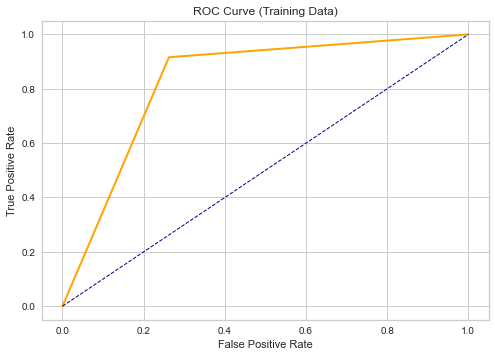

In [87]:
#Using a cross validation to predict the probabilities of the training data
best_mlp_proba_cv = cross_val_predict(best_knn, X_train, y_train,method='predict_proba', cv=5)

y_train_cv_proba_best_mlp = best_mlp_proba_cv[:, 1]

#getting the rates and tresholds
fpr, tpr, thresholds = roc_curve(y_train, y_train_cv_proba_best_mlp)

#plotting the ROC Curve using fpr and tpr values
plt.plot(fpr, tpr, color='orange', linewidth=2) 
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC Curve (Training Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [88]:
### Area under ROC curve
roc_auc_score(y_train, y_train_cv_proba_best_mlp)

0.8268138578314275

### Tuning

##### No need tuning takes a long time. best_hyperparameters has the best parameters

In [89]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
#     model.add(layers.Input(shape=(X_train.shape[1],)))

#     for i in range(hp.Int('num_layers', 1, 2)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                             min_value=32,
#                                             max_value=128,
#                                             step=32),
#                                activation='relu'))
#         model.add(layers.Dropout(hp.Float('dropout_' + str(i),
#                                           min_value=0.1,
#                                           max_value=0.5,
#                                           step=0.1)))

#     model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])

#     return model


In [90]:
def build_model(hp):
    input_features = X_train.shape[1]
#    output_units = 2
    output_units = 1
    hp_activation=hp.Choice('activation',values=['relu','tanh'])
    hp_layer_0=hp.Int('units_0', min_value=32, max_value=256, step=32)
    hp_dropout=hp.Float('dropout_0', min_value=0.1, max_value=0.5, step=0.1)
    
    
    model = Sequential()
    model.add(Dense(hp_layer_0, activation=hp_activation, input_shape=(input_features,)))
    model.add(Dropout(hp_dropout))
    
    for i in range(hp.Int('num_layers', min_value=1, max_value=5, step=1) - 1):
        model.add(Dense(hp.Int(f'units_{i + 1}', min_value=32, max_value=256, step=32), activation=hp.Choice(f'activation_{i + 1}',values=['relu','tanh'])))
        model.add(Dropout(hp.Float(f'dropout_{i + 1}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(output_units, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',  # Objective to optimize
                     max_epochs=1000,  # Maximum number of epochs to consider
                     factor=3,  # Reduction factor for the number of epochs and models for each bracket
                     directory='my_dir',
                     project_name='Tuning_Final_Project5')

tuner.search_space_summary()  # Print the search space summary

# Custom callback to stop training after finding the best epoch
class EpochStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= tuner.get_best_epoch():
            self.model.stop_training = True

# Perform the search
# Perform the search
tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])



# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


# Get the best number of epochs
# best_epochs = tuner.get_best_epoch()

# Get the best batch size
# best_batch_size = best_hyperparameters.get('batch_size')

# Print the best hyperparameters found during the search
print("\nBest hyperparameters:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.get(hp_name)}")


INFO:tensorflow:Reloading Tuner from my_dir/Tuning_Final_Project5/tuner0.json
Search space summary
Default search space size: 17
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 (Float)
{'default': 0.1, 'conditions':

In [91]:
best_model=tuner.hypermodel.build(best_hyperparameters)
history=best_model.fit(X_train,y_train,epochs=150,batch_size=50)
print("Evaluating on test data")
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}\nTest accuracy: {accuracy*100}")

Epoch 1/150
54/54 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.6214
Epoch 2/150
54/54 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.6756
Epoch 3/150
54/54 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.6944
Epoch 4/150
54/54 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.6970
Epoch 5/150
54/54 [==============================] - 0s 1ms/step - loss: 0.5767 - accuracy: 0.7124
Epoch 6/150
54/54 [==============================] - 0s 1ms/step - loss: 0.5733 - accuracy: 0.7083
Epoch 7/150
54/54 [==============================] - 0s 1ms/step - loss: 0.5412 - accuracy: 0.7316
Epoch 8/150
54/54 [==============================] - 0s 1ms/step - loss: 0.5238 - accuracy: 0.7361
Epoch 9/150
54/54 [==============================] - 0s 1ms/step - loss: 0.5051 - accuracy: 0.7496
Epoch 10/150
54/54 [==============================] - 0s 1ms/step - loss: 0.4954 - accuracy: 0.7549
Epoch 11/

54/54 [==============================] - 0s 1ms/step - loss: 0.0870 - accuracy: 0.9692
Epoch 84/150
54/54 [==============================] - 0s 1ms/step - loss: 0.1032 - accuracy: 0.9639
Epoch 85/150
54/54 [==============================] - 0s 1ms/step - loss: 0.1108 - accuracy: 0.9609
Epoch 86/150
54/54 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9669
Epoch 87/150
54/54 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9673
Epoch 88/150
54/54 [==============================] - 0s 1ms/step - loss: 0.1166 - accuracy: 0.9545
Epoch 89/150
54/54 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9632
Epoch 90/150
54/54 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.9688
Epoch 91/150
54/54 [==============================] - 0s 1ms/step - loss: 0.1007 - accuracy: 0.9662
Epoch 92/150
54/54 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.9688
Epoch 93/150


### Trying dropping features also considering just one hidden layer

In [92]:
#Variable Correlations with the target "Quality"
shuffled_df.corr()['ANYCHD'].sort_values(ascending=False)

ANYCHD      1.000000
PREVHYP     0.239471
AGE         0.219232
SYSBP       0.201755
DIABETES    0.160649
GLUCOSE     0.107078
DIABP       0.099126
BPMEDS      0.096639
BMI         0.077852
LDLC        0.073684
TOTCHOL     0.042278
HEARTRTE    0.022615
CIGPDAY    -0.015154
educ       -0.089874
HDLC       -0.138398
SEX        -0.188372
Name: ANYCHD, dtype: float64

In [93]:
df_drop = shuffled_df.drop(['HEARTRTE','educ'],axis=1)

In [94]:
y_drop = df_drop["ANYCHD"]
X_drop = df_drop.drop(['ANYCHD'],axis=1)
print(X_drop.shape)
X_drop.head()

(3326, 13)


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
587     2    240.0   58  166.0   90.0        0  28.78         0     1.0   
31      2    180.0   52  195.0  107.0        2  22.36         0     1.0   
854     1    330.0   50  131.0   83.0        1  26.20         0     0.0   
363     2    198.0   47  135.0   73.0        3  20.81         0     0.0   
1869    2    145.0   51  122.0   80.0        0  32.91         0     0.0   

      GLUCOSE  PREVHYP  HDLC   LDLC  
587      76.0        1  74.0  157.0  
31       75.0        1  60.0  120.0  
854      87.0        0  34.0  296.0  
363      98.0        1  28.0  170.0  
1869     79.0        0  32.0  113.0

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_drop,y_drop, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2660, 13)
y_train shape: (2660,)
X_test shape: (666, 13)
y_test shape: (666,)


In [97]:
def build_model(hp):
    input_features = X_train.shape[1]
#    output_units = 2
    output_units = 1
    hp_activation=hp.Choice('activation',values=['relu','tanh'])
    hp_layer_0=hp.Int('units_0', min_value=32, max_value=256, step=32)
    hp_dropout=hp.Float('dropout_0', min_value=0.1, max_value=0.5, step=0.1)
    
    
    model = Sequential()
    model.add(Dense(hp_layer_0, activation=hp_activation, input_shape=(input_features,)))
    model.add(Dropout(hp_dropout))
    
    for i in range(hp.Int('num_layers', min_value=0, max_value=5, step=1) - 1):
        model.add(Dense(hp.Int(f'units_{i + 1}', min_value=32, max_value=256, step=32), activation=hp.Choice(f'activation_{i + 1}',values=['relu','tanh'])))
        model.add(Dropout(hp.Float(f'dropout_{i + 1}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(output_units, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

print("Start of tuner")
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',  # Objective to optimize
                     max_epochs=1000,  # Maximum number of epochs to consider
                     factor=3,  # Reduction factor for the number of epochs and models for each bracket
                     directory='my_dir',
                     project_name='Tuning_Final_Project7')

print("Start of Space Summary")
tuner.search_space_summary()  # Print the search space summary

# Custom callback to stop training after finding the best epoch
class EpochStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= tuner.get_best_epoch():
            self.model.stop_training = True

# Perform the search
# Perform the search
print("Start of search")
tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])



# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


# Get the best number of epochs
# best_epochs = tuner.get_best_epoch()

# Get the best batch size
# best_batch_size = best_hyperparameters.get('batch_size')

# Print the best hyperparameters found during the search
print("\nBest hyperparameters:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.get(hp_name)}")


Start of tuner
INFO:tensorflow:Reloading Tuner from my_dir/Tuning_Final_Project7/tuner0.json
Start of Space Summary
Search space summary
Default search space size: 17
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 

In [98]:
best_model=tuner.hypermodel.build(best_hyperparameters)
history=best_model.fit(X_train,y_train,epochs=100,batch_size=50)
print("Evaluating on test data")
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}\nTest accuracy: {accuracy*100}")

Epoch 1/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.6289
Epoch 2/100
54/54 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.6609
Epoch 3/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6220 - accuracy: 0.6654
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6138 - accuracy: 0.6699
Epoch 5/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.6737
Epoch 6/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6102 - accuracy: 0.6786
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 0.6020 - accuracy: 0.6797
Epoch 8/100
54/54 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.6910
Epoch 9/100
54/54 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.6887
Epoch 10/100
54/54 [==============================] - 0s 2ms/step - loss: 0.5871 - accuracy: 0.6910
Epoch 11/

54/54 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.8812
Epoch 84/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.8850
Epoch 85/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.8782
Epoch 86/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.8831
Epoch 87/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2712 - accuracy: 0.8868
Epoch 88/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.8872
Epoch 89/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2622 - accuracy: 0.8936
Epoch 90/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.8853
Epoch 91/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2803 - accuracy: 0.8759
Epoch 92/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.8865
Epoch 93/100


### Clustering

#### Preprocessing data for clustering

In [99]:
#drop target and storing it in a target variables
target=df['ANYCHD']
#data for unsupervised learning without target variable
data_ul = df.drop(['ANYCHD'],axis=1)
print(data_ul.shape)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_ul)

# convert numpy array to pandas dataframe
data_scaled = pd.DataFrame(data_scaled, columns=data_ul.columns)

(2236, 15)


In [100]:
data_ul.isnull().sum()

SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVHYP     0
HDLC        0
LDLC        0
dtype: int64

In [101]:
data_ul

SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
0       2    237.0   58  108.0   66.0        0  28.50         0     0.0   
1       2    220.0   55  180.0  106.0        0  31.17         1     1.0   
2       2    320.0   57  110.0   46.0        2  22.02         0     0.0   
3       1    280.0   64  168.0  100.0        0  25.72         0     0.0   
4       1    211.0   55  173.0  123.0        0  29.11         0     1.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2231    2    243.0   68  110.0   66.0        0  24.30         0     0.0   
2232    1    219.0   70  163.5   75.0        0  25.26         0     0.0   
2233    2    228.0   60  205.0  100.0        1  22.37         0     0.0   
2234    2    251.0   56  145.0   92.0        2  21.97         0     1.0   
2235    1    153.0   52  143.0   89.0        0  25.74         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  
0         80.0     71.0   2.0        0  54.0  141.0  
1         86.0     81.0   2.0        1  46.0  135.0  
2         75.0     87.0   2.0        0  34.0  286.0  
3         92.0     82.0   1.0        1  44.0  236.0  
4         75.0     85.0   1.0        1  48.0  163.0  
...        ...      ...   ...      ...   ...    ...  
2231      80.0    108.0   1.0        1  65.0  178.0  
2232      65.0    103.0   3.0        1  50.0  169.0  
2233      80.0     91.0   2.0        1  47.0  181.0  
2234      95.0     90.0   1.0        1  70.0  181.0  
2235      65.0     72.0   3.0        1  30.0  123.0  

[2236 rows x 15 columns]

In [102]:
data_scaled

SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
0     0.876122 -0.013226 -0.261252 -1.388968 -1.324075 -0.657971  0.707741   
1     0.876122 -0.388685 -0.622960  1.834139  2.207002 -0.657971  1.395451   
2     0.876122  1.819899 -0.381821 -1.299437 -3.089613  2.243849 -0.961306   
3    -1.141394  0.936465  0.462164  1.296954  1.677340 -0.657971 -0.008301   
4    -1.141394 -0.587458 -0.622960  1.520781  3.707710 -0.657971  0.864858   
...        ...       ...       ...       ...       ...       ...       ...   
2231  0.876122  0.119289  0.944442 -1.299437 -1.324075 -0.657971 -0.374049   
2232 -1.141394 -0.410771  1.185580  1.095510 -0.529583 -0.657971 -0.126782   
2233  0.876122 -0.211998 -0.020113  2.953273  1.677340  0.792939 -0.871157   
2234  0.876122  0.295976 -0.502390  0.267351  0.971125  2.243849 -0.974185   
2235 -1.141394 -1.868436 -0.984668  0.177820  0.706294 -0.657971 -0.003149   

      DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
0    -0.275744 -0.410907  0.189929 -0.620640 -0.066964 -1.187216  0.324880   
1     3.626555  2.433639  0.671610 -0.278324 -0.066964  0.842306 -0.188726   
2    -0.275744 -0.410907 -0.211471 -0.072934 -0.066964 -1.187216 -0.959136   
3    -0.275744 -0.410907  1.153291 -0.244092 -1.026786  0.842306 -0.317128   
4    -0.275744  2.433639 -0.211471 -0.141397 -1.026786  0.842306 -0.060325   
...        ...       ...       ...       ...       ...       ...       ...   
2231 -0.275744 -0.410907  0.189929  0.645931 -1.026786  0.842306  1.031089   
2232 -0.275744 -0.410907 -1.014273  0.474773  0.892857  0.842306  0.068077   
2233 -0.275744 -0.410907  0.189929  0.063993 -0.066964  0.842306 -0.124525   
2234 -0.275744  2.433639  1.394132  0.029761 -1.026786  0.842306  1.352093   
2235 -0.275744 -0.410907 -1.014273 -0.586408  0.892857  0.842306 -1.215939   

          LDLC  
0    -0.901668  
1    -1.030977  
2     2.223280  
3     1.145712  
4    -0.427538  
...        ...  
2231 -0.104268  
2232 -0.298230  
2233 -0.039614  
2234 -0.039614  
2235 -1.289593  

[2236 rows x 15 columns]

#### Determining best k

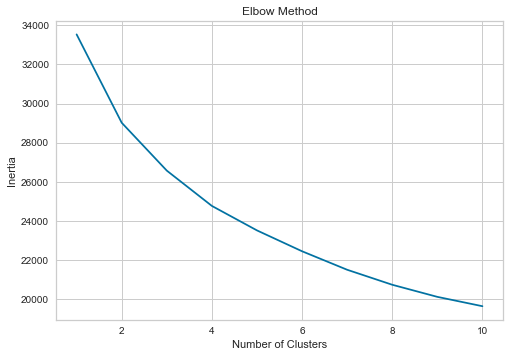

In [103]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


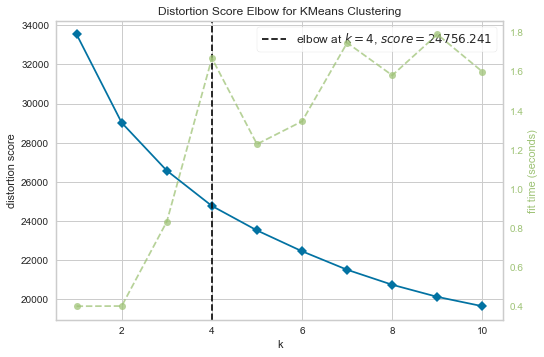

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,11))
 
visualizer.fit(data_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Text(0, 0.5, 'Cluster Labels')

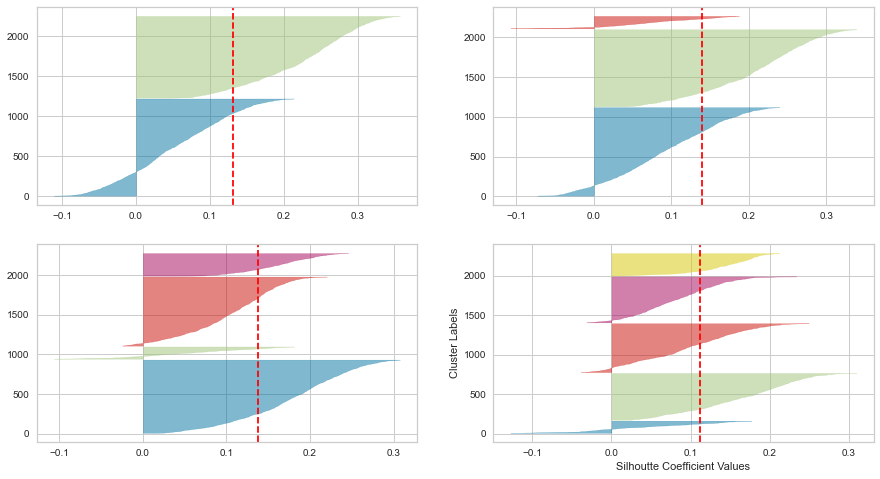

In [105]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))


for i in [2, 3, 4, 5]:
    
#     Create KMeans instances for different number of clusters
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled) 
    
plt.xlabel('Silhoutte Coefficient Values')
plt.ylabel('Cluster Labels')

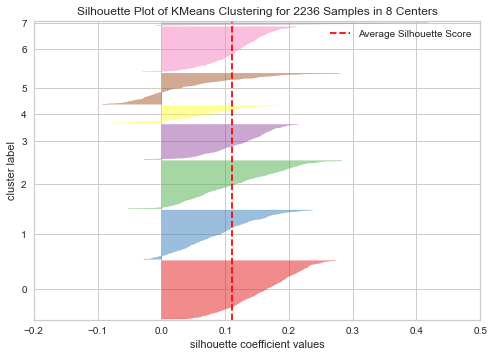

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2236 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [106]:
# Create a range of k values to try
k_values = range(2, 11)

# Iterate over the k values and compute silhouette scores
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    silhouette_scores.append(kmeans.inertia_)

#SilhouetteVisualizer
visualizer = SilhouetteVisualizer(KMeans(random_state=42))

# Fit the visualizer to the data and visualize
visualizer.fit(data_scaled)
visualizer.show()


#### Perform Clustering

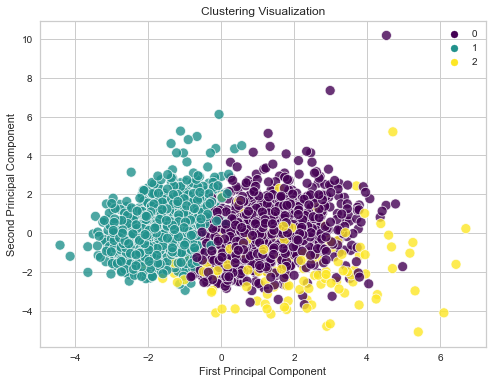

In [107]:
# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Perform KMeans clustering with the optimal number of clusters
optimal_clusters = 3
# Replace this with the optimal number of clusters based on the elbow method plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters_labels = kmeans.fit_predict(data_scaled)
# centroids = kmeans.cluster_centers_

# Visualize the clusters in the 2D PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters_labels, palette='viridis', s=100, alpha=0.8)
# plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'white')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()


In [108]:
# Calculate silhouette score
score = silhouette_score(data_scaled, clusters_labels)
print("Silhouette score:", score)

Silhouette score: 0.13896940365125618


### Cross Clustering

In [109]:
#data_scaled has no target variable. This will be used to create clustering models m0,m1,m2,m3
data_scaled.head()

SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
0  0.876122 -0.013226 -0.261252 -1.388968 -1.324075 -0.657971  0.707741   
1  0.876122 -0.388685 -0.622960  1.834139  2.207002 -0.657971  1.395451   
2  0.876122  1.819899 -0.381821 -1.299437 -3.089613  2.243849 -0.961306   
3 -1.141394  0.936465  0.462164  1.296954  1.677340 -0.657971 -0.008301   
4 -1.141394 -0.587458 -0.622960  1.520781  3.707710 -0.657971  0.864858   

   DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
0 -0.275744 -0.410907  0.189929 -0.620640 -0.066964 -1.187216  0.324880   
1  3.626555  2.433639  0.671610 -0.278324 -0.066964  0.842306 -0.188726   
2 -0.275744 -0.410907 -0.211471 -0.072934 -0.066964 -1.187216 -0.959136   
3 -0.275744 -0.410907  1.153291 -0.244092 -1.026786  0.842306 -0.317128   
4 -0.275744  2.433639 -0.211471 -0.141397 -1.026786  0.842306 -0.060325   

       LDLC  
0 -0.901668  
1 -1.030977  
2  2.223280  
3  1.145712  
4 -0.427538

In [110]:
# data_scaled=data_scaled.drop(['cluster_m0'], axis=1)

In [111]:
data_scaled.isnull().sum()

SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVHYP     0
HDLC        0
LDLC        0
dtype: int64

In [112]:
# Creating model m0 for all data
kmeans = KMeans(n_clusters=3, random_state=42)
m0 = kmeans.fit(data_scaled)

# Add the clusters labels to the dataframe
data_scaled['cluster_m0'] = m0.labels_

data_scaled

SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
0     0.876122 -0.013226 -0.261252 -1.388968 -1.324075 -0.657971  0.707741   
1     0.876122 -0.388685 -0.622960  1.834139  2.207002 -0.657971  1.395451   
2     0.876122  1.819899 -0.381821 -1.299437 -3.089613  2.243849 -0.961306   
3    -1.141394  0.936465  0.462164  1.296954  1.677340 -0.657971 -0.008301   
4    -1.141394 -0.587458 -0.622960  1.520781  3.707710 -0.657971  0.864858   
...        ...       ...       ...       ...       ...       ...       ...   
2231  0.876122  0.119289  0.944442 -1.299437 -1.324075 -0.657971 -0.374049   
2232 -1.141394 -0.410771  1.185580  1.095510 -0.529583 -0.657971 -0.126782   
2233  0.876122 -0.211998 -0.020113  2.953273  1.677340  0.792939 -0.871157   
2234  0.876122  0.295976 -0.502390  0.267351  0.971125  2.243849 -0.974185   
2235 -1.141394 -1.868436 -0.984668  0.177820  0.706294 -0.657971 -0.003149   

      DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
0    -0.275744 -0.410907  0.189929 -0.620640 -0.066964 -1.187216  0.324880   
1     3.626555  2.433639  0.671610 -0.278324 -0.066964  0.842306 -0.188726   
2    -0.275744 -0.410907 -0.211471 -0.072934 -0.066964 -1.187216 -0.959136   
3    -0.275744 -0.410907  1.153291 -0.244092 -1.026786  0.842306 -0.317128   
4    -0.275744  2.433639 -0.211471 -0.141397 -1.026786  0.842306 -0.060325   
...        ...       ...       ...       ...       ...       ...       ...   
2231 -0.275744 -0.410907  0.189929  0.645931 -1.026786  0.842306  1.031089   
2232 -0.275744 -0.410907 -1.014273  0.474773  0.892857  0.842306  0.068077   
2233 -0.275744 -0.410907  0.189929  0.063993 -0.066964  0.842306 -0.124525   
2234 -0.275744  2.433639  1.394132  0.029761 -1.026786  0.842306  1.352093   
2235 -0.275744 -0.410907 -1.014273 -0.586408  0.892857  0.842306 -1.215939   

          LDLC  cluster_m0  
0    -0.901668           1  
1    -1.030977           2  
2     2.223280           1  
3     1.145712           0  
4    -0.427538           0  
...        ...         ...  
2231 -0.104268           1  
2232 -0.298230           0  
2233 -0.039614           0  
2234 -0.039614           0  
2235 -1.289593           0  

[2236 rows x 16 columns]

In [113]:
# Create empty dictionary to store the new models and dataframes for each respective model
models = {}
dataframes={}
dataframes_scaled={}
#giving labels to the regular data(not standardized)
data_ul['cluster_m0']=data_scaled['cluster_m0']


# For each cluster in m0, create a new model
for cluster in range(3):
    print(cluster)
    # Filtering the data for the current cluster. Only using the instances with the correct cluster label
    cluster_data = data_ul[data_ul['cluster_m0'] == cluster].copy()
    cluster_data=cluster_data.drop('cluster_m0', axis=1)
    
    cluster_data_scaled=data_scaled[data_scaled['cluster_m0'] == cluster].copy()
    cluster_data_scaled=cluster_data_scaled.drop('cluster_m0', axis=1)
    # Fit a new k-means model to the data of the current cluster still scaled  but saving in the dataframe sictionary not scaled
    kmeans = KMeans(n_clusters=3, random_state=42)
    model = kmeans.fit(cluster_data_scaled)
    
# Add the new model to the dictionary
    models[f'm{cluster+1}'] = model
#add dataframe for the current cluster with respective labels to dataframes dictionary
    dataframes[f'data_m{cluster+1}']=cluster_data
#adding a new clumn in the dataframe
    dataframes[f'data_m{cluster+1}'][f'cluster_m{cluster+1}'] = model.labels_
    
    
    
    dataframes_scaled[f'data_m{cluster+1}']=cluster_data_scaled
    dataframes_scaled[f'data_m{cluster+1}'][f'cluster_m{cluster+1}'] = model.labels_
    
#dropping labels
data_ul=data_ul.drop(['cluster_m0'],axis=1)


0
1
2


In [114]:
# Display data of each cluster in each model
for cluster in range(3):
    print(f"Data in cluster {cluster} of m0:")
    display(data_scaled[data_scaled['cluster_m0'] == cluster])

# Display data of each cluster in m1, m2, and m3
for i,data in enumerate(dataframes.values()):
    for cluster in range(3):
        print(f"Data in cluster {cluster} of m{i+1}:")
        display(data[data[f'cluster_m{i+1}'] == cluster])


Data in cluster 0 of m0:


SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
3    -1.141394  0.936465  0.462164  1.296954  1.677340 -0.657971 -0.008301   
4    -1.141394 -0.587458 -0.622960  1.520781  3.707710 -0.657971  0.864858   
6     0.876122  0.583092 -1.105237  0.088289  0.000079  0.792939 -0.252991   
7    -1.141394 -0.499114 -0.020113  0.244968 -0.088198  0.792939 -0.719191   
8     0.876122 -0.565372 -1.346376  1.073128  1.324233  0.792939  1.467570   
...        ...       ...       ...       ...       ...       ...       ...   
2224 -1.141394 -0.985003 -0.020113  0.177820  0.971125 -0.657971 -0.252991   
2232 -1.141394 -0.410771  1.185580  1.095510 -0.529583 -0.657971 -0.126782   
2233  0.876122 -0.211998 -0.020113  2.953273  1.677340  0.792939 -0.871157   
2234  0.876122  0.295976 -0.502390  0.267351  0.971125  2.243849 -0.974185   
2235 -1.141394 -1.868436 -0.984668  0.177820  0.706294 -0.657971 -0.003149   

      DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
3    -0.275744 -0.410907  1.153291 -0.244092 -1.026786  0.842306 -0.317128   
4    -0.275744  2.433639 -0.211471 -0.141397 -1.026786  0.842306 -0.060325   
6    -0.275744 -0.410907  0.591330  0.269383 -0.066964  0.842306  0.581683   
7    -0.275744 -0.410907 -1.656514  0.063993  0.892857  0.842306  0.838487   
8    -0.275744 -0.410907  0.350490 -0.175629 -0.066964  0.842306 -0.573931   
...        ...       ...       ...       ...       ...       ...       ...   
2224 -0.275744 -0.410907 -0.452312 -0.312555 -1.026786  0.842306 -0.252927   
2232 -0.275744 -0.410907 -1.014273  0.474773  0.892857  0.842306  0.068077   
2233 -0.275744 -0.410907  0.189929  0.063993 -0.066964  0.842306 -0.124525   
2234 -0.275744  2.433639  1.394132  0.029761 -1.026786  0.842306  1.352093   
2235 -0.275744 -0.410907 -1.014273 -0.586408  0.892857  0.842306 -1.215939   

          LDLC  cluster_m0  
3     1.145712           0  
4    -0.427538           0  
6     0.499171           0  
7    -1.030977           0  
8    -0.233576           0  
...        ...         ...  
2224 -0.750809           0  
2232 -0.298230           0  
2233 -0.039614           0  
2234 -0.039614           0  
2235 -1.289593           0  

[1111 rows x 16 columns]

Data in cluster 1 of m0:


SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
0     0.876122 -0.013226 -0.261252 -1.388968 -1.324075 -0.657971  0.707741   
2     0.876122  1.819899 -0.381821 -1.299437 -3.089613  2.243849 -0.961306   
5     0.876122 -1.735921 -0.864098 -0.672722 -0.264752 -0.657971  0.223511   
10    0.876122 -0.256170 -0.743529 -0.583191 -0.529583  2.243849 -1.072061   
14    0.876122  1.334010  1.426719 -1.344202 -1.853736 -0.657971  0.115332   
...        ...       ...       ...       ...       ...       ...       ...   
2218  0.876122  0.450577  0.341595  0.222586 -1.677182  0.792939 -0.974185   
2220 -1.141394 -1.161689  0.221026 -0.359364 -0.088198 -0.657971  0.143665   
2225 -1.141394  0.008860  0.221026 -0.493660 -0.970967 -0.657971 -1.226602   
2228 -1.141394  0.803950  1.185580 -0.404130 -0.353029 -0.657971 -0.152539   
2231  0.876122  0.119289  0.944442 -1.299437 -1.324075 -0.657971 -0.374049   

      DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
0    -0.275744 -0.410907  0.189929 -0.620640 -0.066964 -1.187216  0.324880   
2    -0.275744 -0.410907 -0.211471 -0.072934 -0.066964 -1.187216 -0.959136   
5    -0.275744 -0.410907 -0.773433  1.570186  0.892857  0.842306  0.260679   
10   -0.275744 -0.410907  0.591330  0.440541 -0.066964 -1.187216  2.250904   
14   -0.275744 -0.410907  0.189929  0.372078 -1.026786 -1.187216 -0.702333   
...        ...       ...       ...       ...       ...       ...       ...   
2218 -0.275744 -0.410907 -0.933993 -1.065651 -1.026786  0.842306  1.031089   
2220 -0.275744 -0.410907 -0.291752  0.406309 -1.026786 -1.187216  0.517483   
2225 -0.275744 -0.410907 -0.131191  0.132456 -1.026786 -1.187216 -1.151738   
2228 -0.275744 -0.410907  0.189929  0.132456 -1.026786 -1.187216  0.710085   
2231 -0.275744 -0.410907  0.189929  0.645931 -1.026786  0.842306  1.031089   

          LDLC  cluster_m0  
0    -0.901668           1  
2     2.223280           1  
5    -1.655966           1  
10   -0.880117           1  
14    1.662944           1  
...        ...         ...  
2218  0.219003           1  
2220 -1.181836           1  
2225  0.520722           1  
2228  0.671582           1  
2231 -0.104268           1  

[968 rows x 16 columns]

Data in cluster 2 of m0:


SEX   TOTCHOL       AGE     SYSBP     DIABP   CIGPDAY       BMI  \
1     0.876122 -0.388685 -0.622960  1.834139  2.207002 -0.657971  1.395451   
11    0.876122  1.002723  0.462164  0.894066 -1.059244 -0.657971  1.848772   
16    0.876122  0.251804  1.426719  0.804535  0.529740 -0.657971  0.978189   
33    0.876122 -0.035312  1.065011 -0.627956 -0.617859  0.792939 -0.840249   
53    0.876122  0.803950  1.426719 -0.001241 -0.441306 -0.657971  0.473353   
...        ...       ...       ...       ...       ...       ...       ...   
2215  0.876122 -0.388685 -0.743529  0.491178  1.059402 -0.657971 -0.747524   
2226 -1.141394  0.008860 -0.261252  1.565547  0.176633  2.243849 -0.541469   
2227 -1.141394 -1.073346 -0.622960 -0.314599  0.000079 -0.657971  1.807561   
2229  0.876122 -0.189913  0.221026  2.192262  0.882848 -0.657971  2.314972   
2230  0.876122  0.649349  0.341595  0.938832  0.618017 -0.657971 -0.039209   

      DIABETES    BPMEDS  HEARTRTE   GLUCOSE      educ   PREVHYP      HDLC  \
1     3.626555  2.433639  0.671610 -0.278324 -0.066964  0.842306 -0.188726   
11    3.626555 -0.410907 -0.612872  4.822192 -1.026786  0.842306 -0.252927   
16    3.626555 -0.410907 -1.014273 -0.552177 -1.026786  0.842306  1.865700   
33    3.626555 -0.410907  0.992731  0.474773 -1.026786 -1.187216 -1.215939   
53    3.626555 -0.410907  0.270210 -0.141397  0.892857  0.842306  1.994101   
...        ...       ...       ...       ...       ...       ...       ...   
2215  3.626555 -0.410907  0.591330 -0.654872 -0.066964  0.842306 -0.060325   
2226  3.626555 -0.410907  2.196933  3.110610  1.852679  0.842306  2.186704   
2227  3.626555 -0.410907  0.671610 -0.517945 -1.026786  0.842306 -0.060325   
2229  3.626555  2.433639  0.591330 -0.723335 -1.026786  0.842306 -0.381329   
2230  3.626555 -0.410907  0.350490 -0.620640  0.892857  0.842306  1.031089   

          LDLC  cluster_m0  
1    -1.030977           2  
11    1.188814           2  
16   -0.255127           2  
33    0.499171           2  
53    0.132797           2  
...        ...         ...  
2215 -0.233576           2  
2226 -0.599949           2  
2227 -1.462004           2  
2229  0.068143           2  
2230  0.412965           2  

[157 rows x 16 columns]

Data in cluster 0 of m1:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
7       1    215.0   60  144.5   80.0        1  22.96         0     0.0   
8       2    212.0   49  163.0   96.0        1  31.45         0     0.0   
9       1    162.0   53  152.5  101.0        0  26.43         0     0.0   
15      1    240.0   47  131.0   90.0        0  26.77         0     0.0   
17      1    300.0   48  125.0   83.0        0  34.34         0     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2210    2    195.0   52  152.0   86.0        1  23.96         0     0.0   
2221    1    215.0   60  160.0   84.0        2  25.23         0     0.0   
2224    1    193.0   60  143.0   92.0        0  24.77         0     0.0   
2232    1    219.0   70  163.5   75.0        0  25.26         0     0.0   
2235    1    153.0   52  143.0   89.0        0  25.74         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m1  
7         57.0     91.0   3.0        1  62.0  135.0           0  
8         82.0     84.0   2.0        1  40.0  172.0           0  
9        105.0     78.0   2.0        1  31.0   91.0           0  
15        70.0     76.0   2.0        1  40.0  200.0           0  
17        58.0     96.0   4.0        1  47.0  253.0           0  
...        ...      ...   ...      ...   ...    ...         ...  
2210      55.0     84.0   2.0        1  34.0  161.0           0  
2221      85.0     81.0   2.0        1  41.0  174.0           0  
2224      72.0     80.0   1.0        1  45.0  148.0           0  
2232      65.0    103.0   3.0        1  50.0  169.0           0  
2235      65.0     72.0   3.0        1  30.0  123.0           0  

[410 rows x 16 columns]

Data in cluster 1 of m1:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
4       1    211.0   55  173.0  123.0        0  29.11         0     1.0   
20      1    226.0   49  190.0  123.0        0  45.43         0     1.0   
31      2    180.0   52  195.0  107.0        2  22.36         0     1.0   
39      2    229.0   56  141.0   91.0        0  32.49         0     1.0   
43      2    231.0   65  136.0   70.0        0  23.31         0     1.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2200    2    291.0   66  210.0  100.0        0  32.50         0     1.0   
2205    2    189.0   66  148.0   82.0        0  25.25         0     1.0   
2208    1    194.0   56  197.0  111.0        0  32.13         0     1.0   
2223    2    286.0   64  170.5   85.0        0  27.35         0     1.0   
2234    2    251.0   56  145.0   92.0        2  21.97         0     1.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m1  
4         75.0     85.0   1.0        1  48.0  163.0           1  
20       100.0     73.0   2.0        1  34.0  192.0           1  
31        68.0     75.0   4.0        1  60.0  120.0           1  
39        96.0     96.0   1.0        1  62.0  167.0           1  
43        70.0     86.0   2.0        1  41.0  190.0           1  
...        ...      ...   ...      ...   ...    ...         ...  
2200      78.0     79.0   2.0        1  52.0  239.0           1  
2205      60.0    105.0   1.0        1  52.0  137.0           1  
2208      80.0     95.0   1.0        1  33.0  161.0           1  
2223      60.0     75.0   1.0        1  57.0  229.0           1  
2234      95.0     90.0   1.0        1  70.0  181.0           1  

[284 rows x 16 columns]

Data in cluster 2 of m1:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
3       1    280.0   64  168.0  100.0        0  25.72         0     0.0   
6       2    264.0   51  141.0   81.0        1  24.77         0     0.0   
12      2    236.0   64  150.0   89.0        1  24.01         0     0.0   
13      1    290.0   56  132.0   70.0        2  22.73         0     0.0   
19      1    320.0   53  148.0   89.0        1  22.78         0     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2212    2    243.0   74  154.0   88.0        0  22.88         0     0.0   
2213    2    239.0   73  165.0   70.0        0  22.91         0     0.0   
2219    1    280.0   77  136.0   78.0        0  28.40         0     0.0   
2222    2    280.0   68  145.0   87.0        0  22.55         0     0.0   
2233    2    228.0   60  205.0  100.0        1  22.37         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m1  
3         92.0     82.0   1.0        1  44.0  236.0           2  
6         85.0     97.0   2.0        1  58.0  206.0           2  
12        90.0     80.0   3.0        1  93.0  143.0           2  
13       100.0     90.0   2.0        1  54.0  236.0           2  
19        80.0    110.0   3.0        1  42.0  278.0           2  
...        ...      ...   ...      ...   ...    ...         ...  
2212      78.0     86.0   1.0        1  56.0  187.0           2  
2213      78.0     69.0   1.0        1  50.0  161.0           2  
2219      75.0     88.0   2.0        1  40.0  212.0           2  
2222      68.0     62.0   3.0        1  64.0  216.0           2  
2233      80.0     91.0   2.0        1  47.0  181.0           2  

[417 rows x 16 columns]

Data in cluster 0 of m2:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
2       2    320.0   57  110.0   46.0        2  22.02         0     0.0   
14      2    298.0   72  109.0   60.0        0  26.20         0     0.0   
23      2    293.0   53  127.0   77.0        1  25.68         0     0.0   
36      2    314.0   59  143.0   66.0        1  18.32         0     0.0   
37      2    272.0   64  116.0   66.0        0  23.18         0     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2154    2    266.0   52  130.0   80.0        1  20.01         0     0.0   
2182    2    298.0   65  130.0   80.0        0  26.39         0     0.0   
2184    1    300.0   61  130.0   70.0        0  25.75         0     0.0   
2188    2    260.0   48  133.0   88.0        2  34.27         0     0.0   
2228    1    274.0   70  130.0   77.0        0  25.16         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m2  
2         75.0     87.0   2.0        0  34.0  286.0           0  
14        80.0    100.0   1.0        0  38.0  260.0           0  
23        90.0    115.0   2.0        0  52.0  241.0           0  
36        93.0     96.0   2.0        0  61.0  237.0           0  
37        77.0     74.0   4.0        0  41.0  231.0           0  
...        ...      ...   ...      ...   ...    ...         ...  
2154     100.0     64.0   2.0        0  53.0  213.0           0  
2182      72.0     75.0   3.0        0  58.0  222.0           0  
2184      80.0     84.0   3.0        0  49.0  222.0           0  
2188      85.0     66.0   2.0        0  40.0  220.0           0  
2228      80.0     93.0   1.0        0  60.0  214.0           0  

[230 rows x 16 columns]

Data in cluster 1 of m2:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
18      1    206.0   55  129.0   85.0        3  26.40         0     0.0   
25      1    241.0   58  135.0   70.0        2  25.68         0     0.0   
30      1    216.0   56  117.0   70.0        1  21.35         0     0.0   
32      1    229.0   68  145.0   77.0        1  23.09         0     0.0   
35      1    238.0   50  113.0   75.0        1  23.35         0     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2189    1    249.0   53  110.5   69.0        1  29.44         0     0.0   
2204    1    188.0   53  112.0   70.0        0  27.28         0     0.0   
2214    1    184.0   74  112.0   67.0        0  21.77         0     0.0   
2220    1    185.0   62  131.0   80.0        0  26.31         0     0.0   
2225    1    238.0   62  128.0   70.0        0  20.99         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m2  
18        84.0     69.0   4.0        0  47.0  159.0           1  
25        90.0     93.0   1.0        0  41.0  200.0           1  
30        72.0     49.0   2.0        0  42.0  174.0           1  
32        72.0     83.0   4.0        0  39.0  170.0           1  
35        90.0     89.0   1.0        0  46.0  192.0           1  
...        ...      ...   ...      ...   ...    ...         ...  
2189      65.0     83.0   2.0        0  28.0  221.0           1  
2204      75.0     75.0   3.0        0  45.0  143.0           1  
2214      84.0    111.0   2.0        0  54.0  110.0           1  
2220      74.0    101.0   1.0        0  57.0  128.0           1  
2225      76.0     93.0   1.0        0  31.0  207.0           1  

[335 rows x 16 columns]

Data in cluster 2 of m2:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
0       2    237.0   58  108.0   66.0        0  28.50         0     0.0   
5       2    159.0   53  124.0   78.0        0  26.62         0     0.0   
10      2    226.0   54  126.0   75.0        2  21.59         0     0.0   
22      2    216.0   54  100.0   75.0        1  29.82         0     0.0   
27      2    251.0   59  132.0   77.0        1  19.30         0     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2209    2    234.0   49  123.0   89.0        0  22.91         0     0.0   
2216    2    224.0   50  137.0   70.0        0  23.45         0     0.0   
2217    2    203.0   55  102.0   63.0        1  22.19         0     0.0   
2218    2    258.0   63  144.0   62.0        1  21.97         0     0.0   
2231    2    243.0   68  110.0   66.0        0  24.30         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m2  
0         80.0     71.0   2.0        0  54.0  141.0           2  
5         68.0    135.0   3.0        1  53.0  106.0           2  
10        85.0    102.0   2.0        0  84.0  142.0           2  
22        70.0     68.0   2.0        0  30.0  186.0           2  
27        82.0     76.0   2.0        0  53.0  197.0           2  
...        ...      ...   ...      ...   ...    ...         ...  
2209      70.0     73.0   3.0        0  59.0  175.0           2  
2216      70.0    103.0   2.0        1  67.0  140.0           2  
2217      75.0     68.0   2.0        0  38.0  165.0           2  
2218      66.0     58.0   1.0        1  65.0  193.0           2  
2231      80.0    108.0   1.0        1  65.0  178.0           2  

[403 rows x 16 columns]

Data in cluster 0 of m3:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
11      2    283.0   64  159.0   69.0        0  32.93         1     0.0   
60      1    209.0   62  117.5   67.5        0  25.77         1     0.0   
469     1    302.0   50  185.0  122.0        0  29.29         1     1.0   
474     2    253.0   67  140.0   67.0        0  23.88         1     0.0   
563     1    293.0   75  160.0   70.0        0  22.58         1     0.0   
669     1    192.0   73  137.0   75.0        0  26.92         1     0.0   
859     2    211.0   55  190.0  102.0        0  30.58         1     1.0   
998     2    186.0   64  208.0  108.0        2  31.11         1     0.0   
1014    2    218.0   70  158.0   69.0        0  23.96         1     1.0   
1062    1    266.0   58  151.0   83.0        1  26.21         1     0.0   
1263    2    267.0   71  139.0   69.0        0  26.13         1     0.0   
1271    2    208.0   74  121.0   68.0        0  16.36         1     0.0   
1334    2    329.0   53  142.5   73.0        0  26.42         1     0.0   
1356    2    224.0   64  160.0  102.0        0  42.16         1     1.0   
1443    1    232.0   70  163.0  100.0        0  27.22         1     0.0   
1445    1    340.0   51  130.0   83.0        1  29.33         1     0.0   
1743    2    203.0   70  167.0   86.0        0  21.51         1     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m3  
11        70.0    230.0   1.0        1  45.0  238.0           0  
60        96.0    265.0   1.0        1  27.0  115.0           0  
469      100.0    334.0   2.0        1  60.0  242.0           0  
474       72.0    334.0   1.0        1  86.0  167.0           0  
563       84.0    380.0   1.0        0  47.0  246.0           0  
669       94.0    333.0   1.0        1  36.0  156.0           0  
859       82.0    478.0   1.0        1  48.0  163.0           0  
998      109.0    410.0   1.0        1  40.0  106.0           0  
1014      75.0    271.0   2.0        1  37.0  181.0           0  
1062     110.0    423.0   2.0        1  50.0  216.0           0  
1263      90.0    260.0   3.0        0  44.0  223.0           0  
1271     100.0    302.0   1.0        1  38.0  170.0           0  
1334     100.0    206.0   1.0        1  15.0  314.0           0  
1356      60.0    314.0   1.0        1  34.0  190.0           0  
1443     100.0    345.0   1.0        1  50.0  175.0           0  
1445     110.0    261.0   2.0        1  44.0  296.0           0  
1743     104.0    296.0   2.0        1  48.0  155.0           0

Data in cluster 1 of m3:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
16      2    249.0   72  157.0   87.0        0  29.55         1     0.0   
33      2    236.0   69  125.0   74.0        1  22.49         1     0.0   
53      2    274.0   72  139.0   76.0        0  27.59         1     0.0   
115     2    274.0   74  160.0   60.0        0  27.04         1     0.0   
127     1    260.0   50  110.0   80.0        0  31.76         1     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2203    1    188.0   64  124.0   72.0        0  26.21         1     0.0   
2215    2    220.0   54  150.0   93.0        0  22.85         1     0.0   
2226    1    238.0   58  174.0   83.0        2  23.65         1     0.0   
2227    1    189.0   55  132.0   81.0        0  32.77         1     0.0   
2230    2    267.0   63  160.0   88.0        0  25.60         1     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m3  
16        65.0     73.0   1.0        1  78.0  171.0           1  
33        90.0    103.0   1.0        0  30.0  206.0           1  
53        81.0     85.0   3.0        1  80.0  189.0           1  
115       54.0     74.0   1.0        1  32.0  152.0           1  
127       94.0     85.0   1.0        0  48.0  212.0           1  
...        ...      ...   ...      ...   ...    ...         ...  
2203      90.0    175.0   1.0        0  36.0  111.0           1  
2215      85.0     70.0   2.0        1  48.0  172.0           1  
2226     105.0    180.0   4.0        1  83.0  155.0           1  
2227      86.0     74.0   1.0        1  48.0  115.0           1  
2230      82.0     71.0   3.0        1  65.0  202.0           1  

[78 rows x 16 columns]

Data in cluster 2 of m3:


SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
1       2    220.0   55  180.0  106.0        0  31.17         1     1.0   
82      1    185.0   53  168.0  112.0        1  30.48         1     1.0   
117     2    340.0   70  135.0   75.0        0  28.54         1     1.0   
124     2    350.0   73  166.0   92.0        0  30.28         1     1.0   
134     1    150.0   69  137.5   96.5        0  32.77         1     0.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2151    2    267.0   65  200.0   89.0        0  25.97         1     1.0   
2163    2    185.0   68  143.0   96.0        0  27.31         1     1.0   
2174    2    248.0   76  184.0   73.0        0  29.47         1     0.0   
2199    1    234.0   70  205.0   85.0        0  26.15         1     1.0   
2229    2    229.0   62  188.0   91.0        0  34.74         1     1.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  cluster_m3  
1         86.0     81.0   2.0        1  46.0  135.0           2  
82       100.0    183.0   4.0        1  33.0  152.0           2  
117       95.0     87.0   1.0        1  44.0  215.0           2  
124       76.0     53.0   3.0        1  93.0  257.0           2  
134       80.0    125.0   1.0        1  40.0  110.0           2  
...        ...      ...   ...      ...   ...    ...         ...  
2151      76.0    200.0   1.0        1  37.0  230.0           2  
2163      96.0     98.0   2.0        1  39.0  137.0           2  
2174      75.0    210.0   1.0        1  22.0  226.0           2  
2199      57.0     66.0   4.0        1  31.0  144.0           2  
2229      85.0     68.0   1.0        1  43.0  186.0           2  

[62 rows x 16 columns]

#### Vizualizing m0 on all data

(2236, 15)
2236
2236


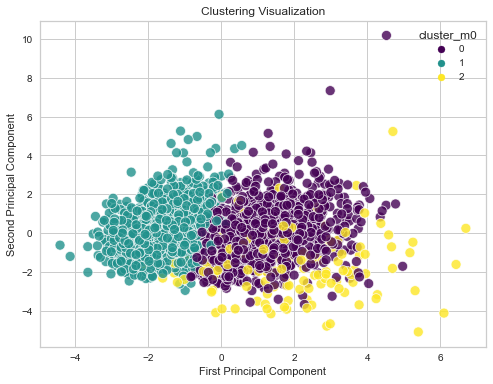

Silhouette score: 0.13896940365125618


In [115]:
#visualize data for different cluster models

# soting cluster labels in labels
labels = data_scaled['cluster_m0']

# Remove labels column from dataframe
data_vis = data_scaled.drop('cluster_m0', axis=1)
print(data_vis.shape)
# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)

print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))

# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()


# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m0 on G1- new model prediction

(1111, 15)
1111
1111
[0 0 1 ... 0 0 1]


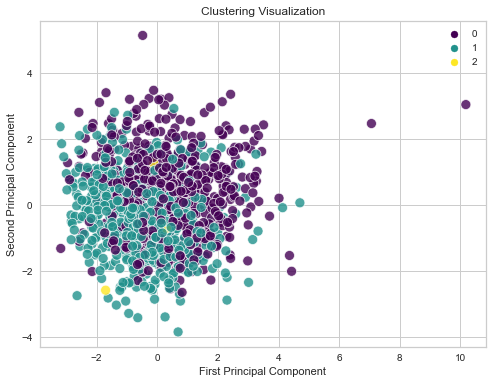

Silhouette score: 0.07156300881815117


In [116]:



#Remove labels column from dataframe
data_vis = dataframes['data_m1'].drop('cluster_m1', axis=1)

# Standardize the data
scaler = StandardScaler()
data_vis = scaler.fit_transform(data_vis)

print(data_vis.shape)
# Predict the cluster labels for the new data
labels = m0.predict(data_vis)


# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))
print(labels)


# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()



# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m0 on all G2

(968, 15)
968
968


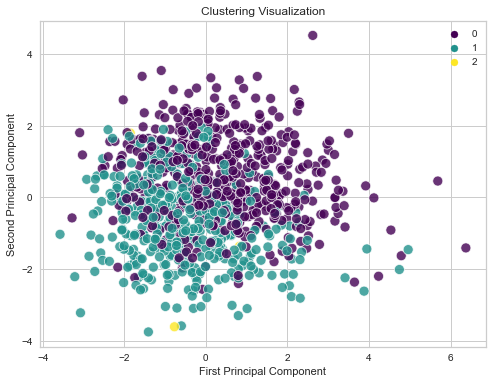

Silhouette score: 0.07684427278286585


In [117]:
#Remove labels column from dataframe
data_vis = dataframes['data_m2'].drop('cluster_m2', axis=1)

# Standardize the data
scaler = StandardScaler()
data_vis = scaler.fit_transform(data_vis)

print(data_vis.shape)

# Predict the cluster labels for the new data
labels = m0.predict(data_vis)


# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))



# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()


# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m0 on all G3

(157, 15)
157
157


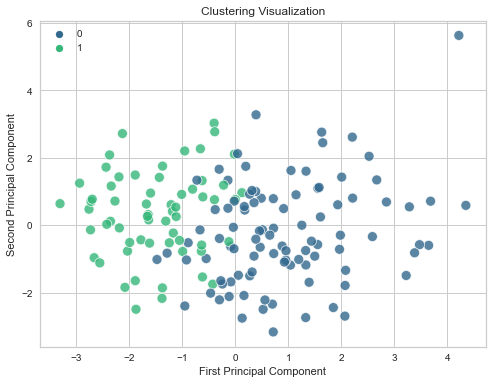

Silhouette score: 0.10122754592949869


In [118]:
#Remove labels column from dataframe
data_vis = dataframes['data_m3'].drop('cluster_m3', axis=1)

# Standardize the data
scaler = StandardScaler()
data_vis = scaler.fit_transform(data_vis)

print(data_vis.shape)
# Predict the cluster labels for the new data
labels = m0.predict(data_vis)


# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))



# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()



# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m1 on G1

1111
1111


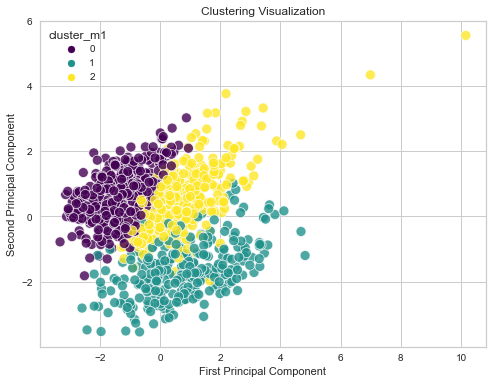

Silhouette score: 0.12365598647367997


In [119]:


# storing cluster labels in labels
labels = dataframes_scaled['data_m1']['cluster_m1']

#Remove labels column from dataframe
data_vis = dataframes_scaled['data_m1'].drop('cluster_m1', axis=1)

# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))

# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()



# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m2 on G2

968
968


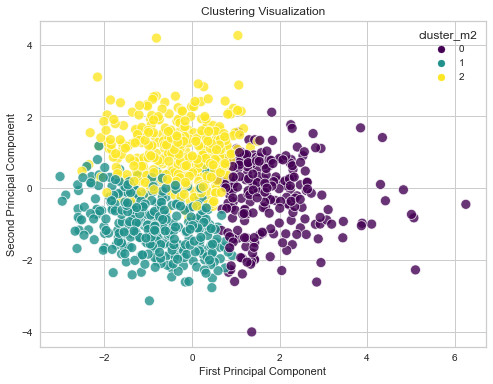

Silhouette score: 0.12299878964296163


In [120]:

# storing cluster labels in labels
labels = dataframes_scaled['data_m2']['cluster_m2']

#Remove labels column from dataframe
data_vis = dataframes_scaled['data_m2'].drop('cluster_m2', axis=1)

# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))

# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()



# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Vizualizing m3 on G3

157
157


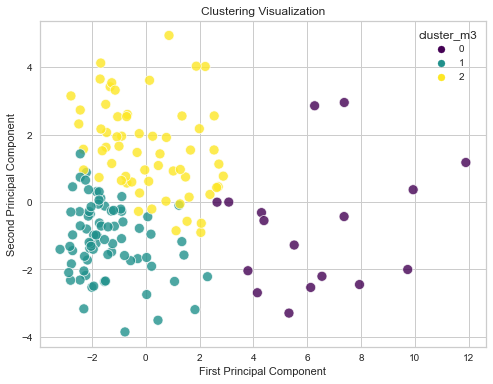

Silhouette score: 0.1499575775328682


In [121]:


# storing cluster labels in labels
labels = dataframes_scaled['data_m3']['cluster_m3']

#Remove labels column from dataframe
data_vis = dataframes_scaled['data_m3'].drop('cluster_m3', axis=1)

# Apply PCA and reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vis)


print(len(reduced_data[:, 0]))
print(len(reduced_data[:, 1]))

# Visualizing the clusters with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Visualization')
plt.show()



# Calculating silhouette score
score = silhouette_score(data_vis, labels)
print("Silhouette score:", score)


#### Analysis of clusters

In [122]:
#giving labels to the regular data(not standardized)
data_ul['target']=target
data_ul['cluster_m0']=data_scaled['cluster_m0']

In [123]:
data_ul

SEX  TOTCHOL  AGE  SYSBP  DIABP  CIGPDAY    BMI  DIABETES  BPMEDS  \
0       2    237.0   58  108.0   66.0        0  28.50         0     0.0   
1       2    220.0   55  180.0  106.0        0  31.17         1     1.0   
2       2    320.0   57  110.0   46.0        2  22.02         0     0.0   
3       1    280.0   64  168.0  100.0        0  25.72         0     0.0   
4       1    211.0   55  173.0  123.0        0  29.11         0     1.0   
...   ...      ...  ...    ...    ...      ...    ...       ...     ...   
2231    2    243.0   68  110.0   66.0        0  24.30         0     0.0   
2232    1    219.0   70  163.5   75.0        0  25.26         0     0.0   
2233    2    228.0   60  205.0  100.0        1  22.37         0     0.0   
2234    2    251.0   56  145.0   92.0        2  21.97         0     1.0   
2235    1    153.0   52  143.0   89.0        0  25.74         0     0.0   

      HEARTRTE  GLUCOSE  educ  PREVHYP  HDLC   LDLC  target  cluster_m0  
0         80.0     71.0   2.0        0  54.0  141.0       0           1  
1         86.0     81.0   2.0        1  46.0  135.0       1           2  
2         75.0     87.0   2.0        0  34.0  286.0       0           1  
3         92.0     82.0   1.0        1  44.0  236.0       0           0  
4         75.0     85.0   1.0        1  48.0  163.0       0           0  
...        ...      ...   ...      ...   ...    ...     ...         ...  
2231      80.0    108.0   1.0        1  65.0  178.0       0           1  
2232      65.0    103.0   3.0        1  50.0  169.0       0           0  
2233      80.0     91.0   2.0        1  47.0  181.0       0           0  
2234      95.0     90.0   1.0        1  70.0  181.0       0           0  
2235      65.0     72.0   3.0        1  30.0  123.0       0           0  

[2236 rows x 17 columns]

#### Analyzing G1

In [124]:
G1=data_ul[data_ul['cluster_m0'] == 0].copy()
G1.describe()

SEX      TOTCHOL          AGE        SYSBP        DIABP  \
count  1111.000000  1111.000000  1111.000000  1111.000000  1111.000000   
mean      1.558056   242.981098    62.171917   152.158866    86.715122   
std       0.496842    46.122385     8.121164    18.518282    10.266344   
min       1.000000   130.000000    45.000000    98.000000    55.000000   
25%       1.000000   212.000000    56.000000   139.250000    80.000000   
50%       2.000000   240.000000    62.000000   150.000000    86.500000   
75%       2.000000   269.500000    69.000000   163.000000    92.500000   
max       2.000000   625.000000    81.000000   225.000000   123.000000   

           CIGPDAY          BMI  DIABETES       BPMEDS     HEARTRTE  \
count  1111.000000  1111.000000    1111.0  1111.000000  1111.000000   
mean      0.369037    26.555284       0.0     0.255626    79.077408   
std       0.658072     4.049378       0.0     0.436409    12.701115   
min       0.000000    15.320000       0.0     0.000000    48.000000   
25%       0.000000    23.900000       0.0     0.000000    70.000000   
50%       0.000000    26.220000       0.0     0.000000    78.000000   
75%       1.000000    28.640000       0.0     1.000000    86.500000   
max       4.000000    46.520000       0.0     1.000000   150.000000   

           GLUCOSE         educ      PREVHYP         HDLC         LDLC  \
count  1111.000000  1111.000000  1111.000000  1111.000000  1111.000000   
mean     86.971197     1.955896     0.992799    48.829883   188.273627   
std      16.708715     0.999477     0.084589    15.972861    47.237609   
min      52.000000     1.000000     0.000000    10.000000    60.000000   
25%      76.000000     1.000000     1.000000    38.000000   156.000000   
50%      84.000000     2.000000     1.000000    47.000000   186.000000   
75%      94.000000     3.000000     1.000000    57.000000   214.000000   
max     207.000000     4.000000     1.000000   189.000000   565.000000   

            target  cluster_m0  
count  1111.000000      1111.0  
mean      0.299730         0.0  
std       0.458346         0.0  
min       0.000000         0.0  
25%       0.000000         0.0  
50%       0.000000         0.0  
75%       1.000000         0.0  
max       1.000000         0.0

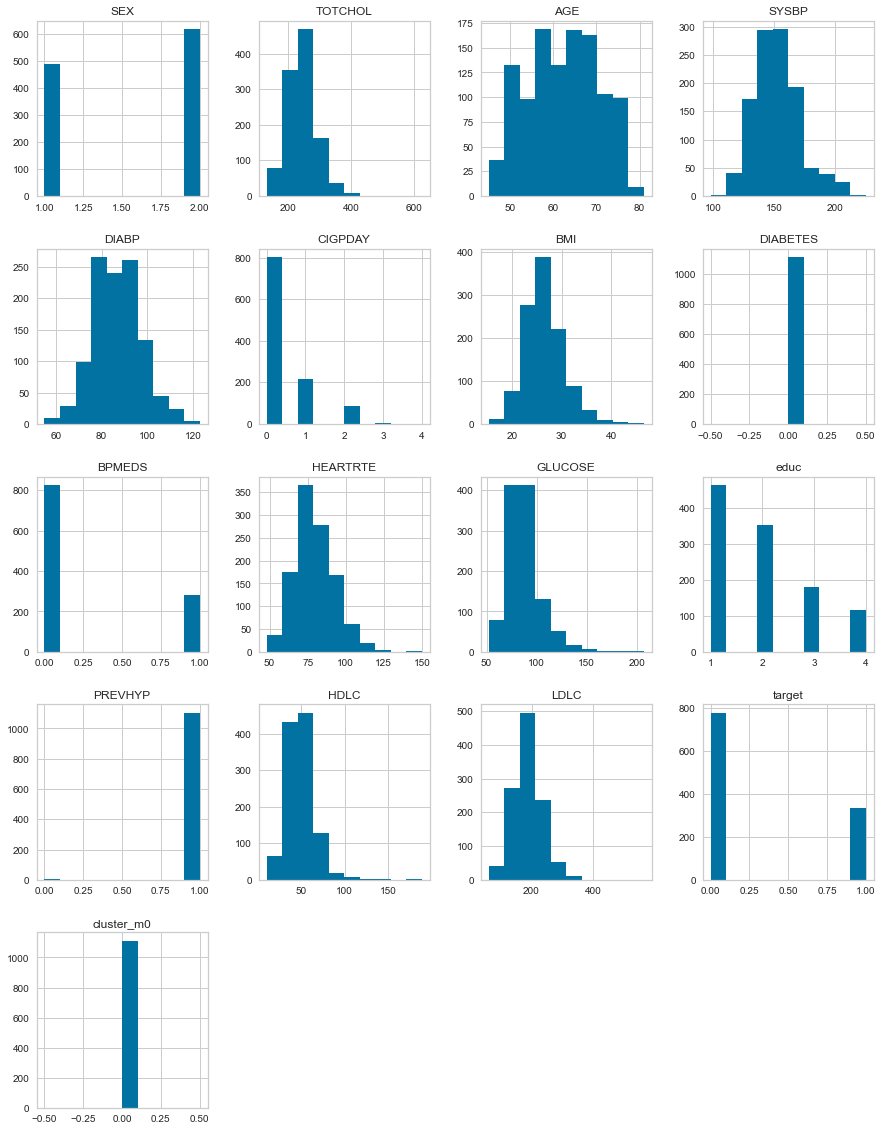

In [125]:
%matplotlib inline
ax = G1.hist(figsize=(15,20))
plt.show()

#### Analyzing negative target on G1

In [126]:
G1_neg=G1[G1['target'] == 0].copy()
G1_neg.describe()

SEX    TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  778.000000  778.00000  778.000000  778.000000  778.000000  778.000000   
mean     1.610540  242.14910   61.435733  151.157455   86.652314    0.375321   
std      0.487942   43.48675    8.103361   18.206150   10.058145    0.665771   
min      1.000000  130.00000   45.000000  115.000000   55.000000    0.000000   
25%      1.000000  213.00000   54.000000  138.000000   80.000000    0.000000   
50%      2.000000  241.00000   61.000000  150.000000   86.500000    0.000000   
75%      2.000000  269.00000   68.000000  162.000000   92.000000    1.000000   
max      2.000000  420.00000   79.000000  225.000000  123.000000    4.000000   

              BMI  DIABETES      BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  778.000000     778.0  778.000000  778.000000  778.000000  778.000000   
mean    26.558740       0.0    0.244216   79.190231   86.564267    1.976864   
std      4.080712       0.0    0.429898   12.446532   16.470686    0.986122   
min     16.580000       0.0    0.000000   50.000000   52.000000    1.000000   
25%     23.892500       0.0    0.000000   70.000000   76.000000    1.000000   
50%     26.220000       0.0    0.000000   78.000000   84.000000    2.000000   
75%     28.645000       0.0    0.000000   88.000000   93.000000    3.000000   
max     45.430000       0.0    1.000000  125.000000  207.000000    4.000000   

          PREVHYP        HDLC        LDLC  target  cluster_m0  
count  778.000000  778.000000  778.000000   778.0       778.0  
mean     0.992288   50.336761  185.789203     0.0         0.0  
std      0.087535   16.358349   45.230333     0.0         0.0  
min      0.000000   10.000000   60.000000     0.0         0.0  
25%      1.000000   40.000000  154.250000     0.0         0.0  
50%      1.000000   49.000000  185.000000     0.0         0.0  
75%      1.000000   58.000000  213.000000     0.0         0.0  
max      1.000000  189.000000  352.000000     0.0         0.0

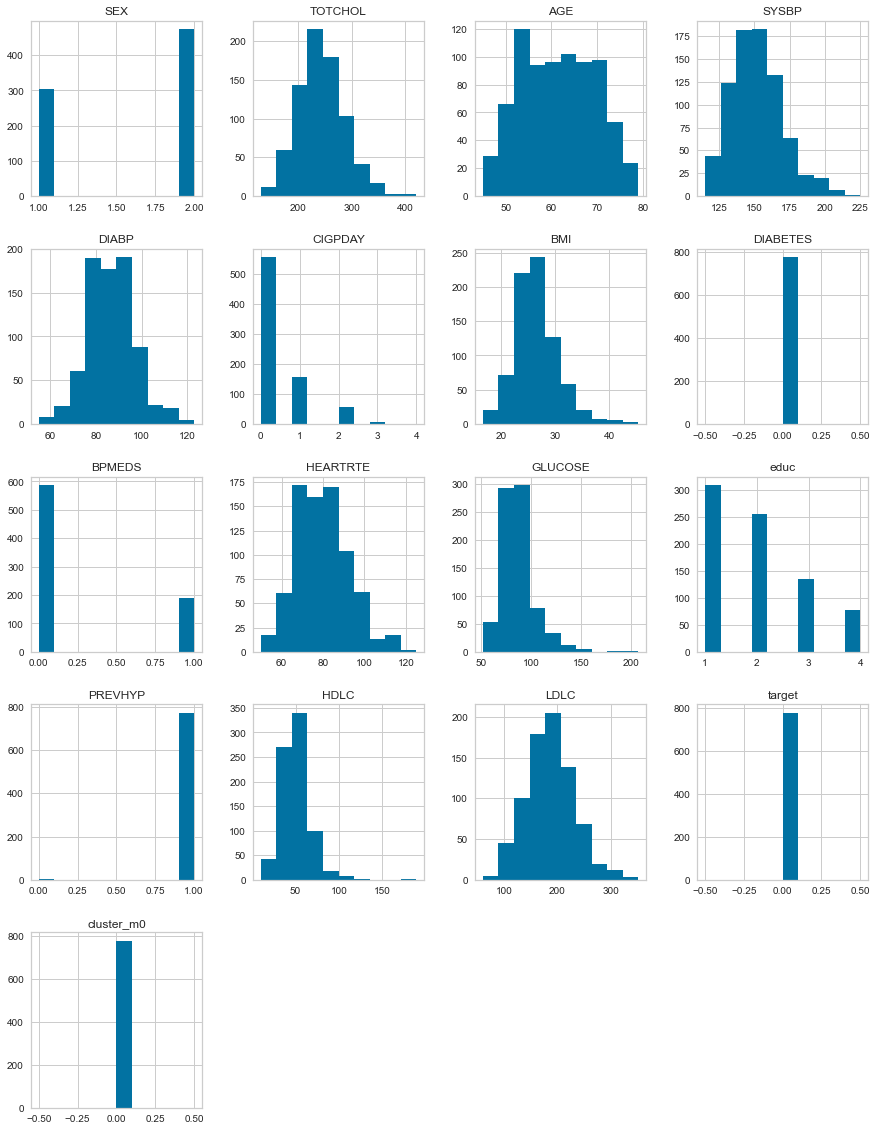

In [127]:
G1_neg.hist(figsize=(15,20))
plt.show()

#### Analyzing positive target on G1

In [128]:
G1_pos=G1[G1['target'] == 1].copy()
G1_pos.describe()

SEX     TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  333.000000  333.000000  333.000000  333.000000  333.000000  333.000000   
mean     1.435435  244.924925   63.891892  154.498498   86.861862    0.354354   
std      0.496560   51.778465    7.911428   19.051156   10.751176    0.640468   
min      1.000000  134.000000   46.000000   98.000000   55.000000    0.000000   
25%      1.000000  210.000000   58.000000  142.000000   80.000000    0.000000   
50%      1.000000  239.000000   64.000000  152.000000   87.000000    0.000000   
75%      2.000000  270.000000   70.000000  166.000000   94.000000    1.000000   
max      2.000000  625.000000   81.000000  209.000000  111.000000    2.000000   

              BMI  DIABETES      BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  333.000000     333.0  333.000000  333.000000  333.000000  333.000000   
mean    26.547207       0.0    0.282282   78.813814   87.921922    1.906907   
std      3.981274       0.0    0.450787   13.292408   17.239801    1.029847   
min     15.320000       0.0    0.000000   48.000000   53.000000    1.000000   
25%     23.950000       0.0    0.000000   70.000000   77.000000    1.000000   
50%     26.200000       0.0    0.000000   78.000000   85.000000    2.000000   
75%     28.630000       0.0    1.000000   86.000000   97.000000    3.000000   
max     46.520000       0.0    1.000000  150.000000  172.000000    4.000000   

          PREVHYP        HDLC        LDLC  target  cluster_m0  
count  333.000000  333.000000  333.000000   333.0       333.0  
mean     0.993994   45.309309  194.078078     1.0         0.0  
std      0.077382   14.456118   51.227404     0.0         0.0  
min      0.000000   14.000000   73.000000     1.0         0.0  
25%      1.000000   36.000000  162.000000     1.0         0.0  
50%      1.000000   43.000000  190.000000     1.0         0.0  
75%      1.000000   53.000000  217.000000     1.0         0.0  
max      1.000000  138.000000  565.000000     1.0         0.0

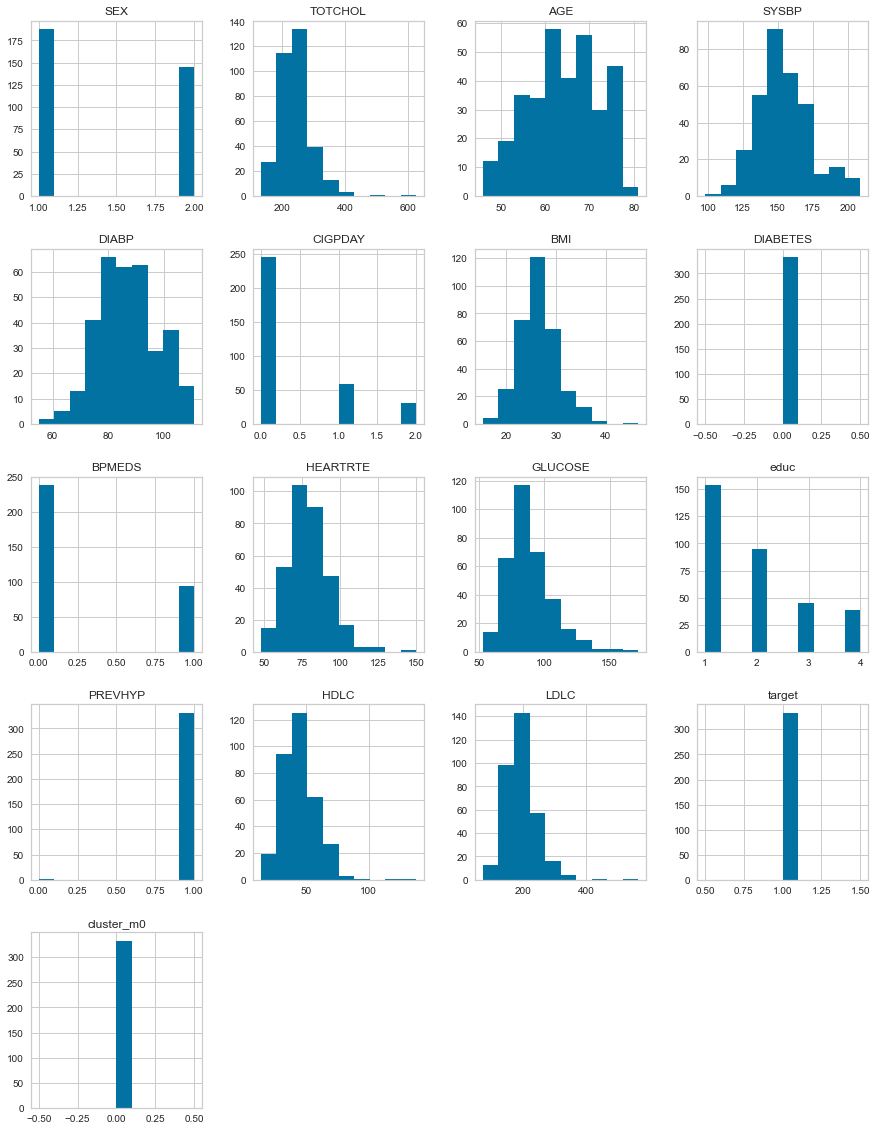

In [129]:
G1_pos.hist(figsize=(15,20))
plt.show()

#### Analyzing G2

In [130]:
G2=data_ul[data_ul['cluster_m0'] == 1].copy()
G2.describe()

SEX     TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  968.000000  968.000000  968.000000  968.000000  968.000000  968.000000   
mean     1.590909  232.315083   57.415289  121.932335   74.146178    0.554752   
std      0.491920   42.899161    7.772027   11.559201    7.484252    0.712641   
min      1.000000  134.000000   44.000000   86.000000   37.000000    0.000000   
25%      1.000000  203.000000   51.000000  113.000000   70.000000    0.000000   
50%      2.000000  228.000000   56.000000  122.000000   74.000000    0.000000   
75%      2.000000  258.000000   63.000000  130.000000   80.000000    1.000000   
max      2.000000  446.000000   80.000000  160.500000   99.000000    4.000000   

              BMI    DIABETES  BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  968.000000  968.000000   968.0  968.000000  968.000000  968.000000   
mean    24.620878    0.001033     0.0   75.222107   83.734504    2.201446   
std      3.216532    0.032141     0.0   11.423920   15.129663    1.060584   
min     14.430000    0.000000     0.0   44.000000   46.000000    1.000000   
25%     22.360000    0.000000     0.0   68.000000   74.000000    1.000000   
50%     24.350000    0.000000     0.0   75.000000   81.000000    2.000000   
75%     26.450000    0.000000     0.0   82.000000   91.000000    3.000000   
max     34.690000    1.000000     0.0  110.000000  162.000000    4.000000   

          PREVHYP        HDLC        LDLC      target  cluster_m0  
count  968.000000  968.000000  968.000000  968.000000       968.0  
mean     0.082645   49.642562  177.522727    0.169421         1.0  
std      0.275487   14.829131   44.108584    0.375318         0.0  
min      0.000000   11.000000   20.000000    0.000000         1.0  
25%      0.000000   40.000000  147.000000    0.000000         1.0  
50%      0.000000   48.000000  173.000000    0.000000         1.0  
75%      0.000000   57.000000  203.250000    0.000000         1.0  
max      1.000000  141.000000  381.000000    1.000000         1.0

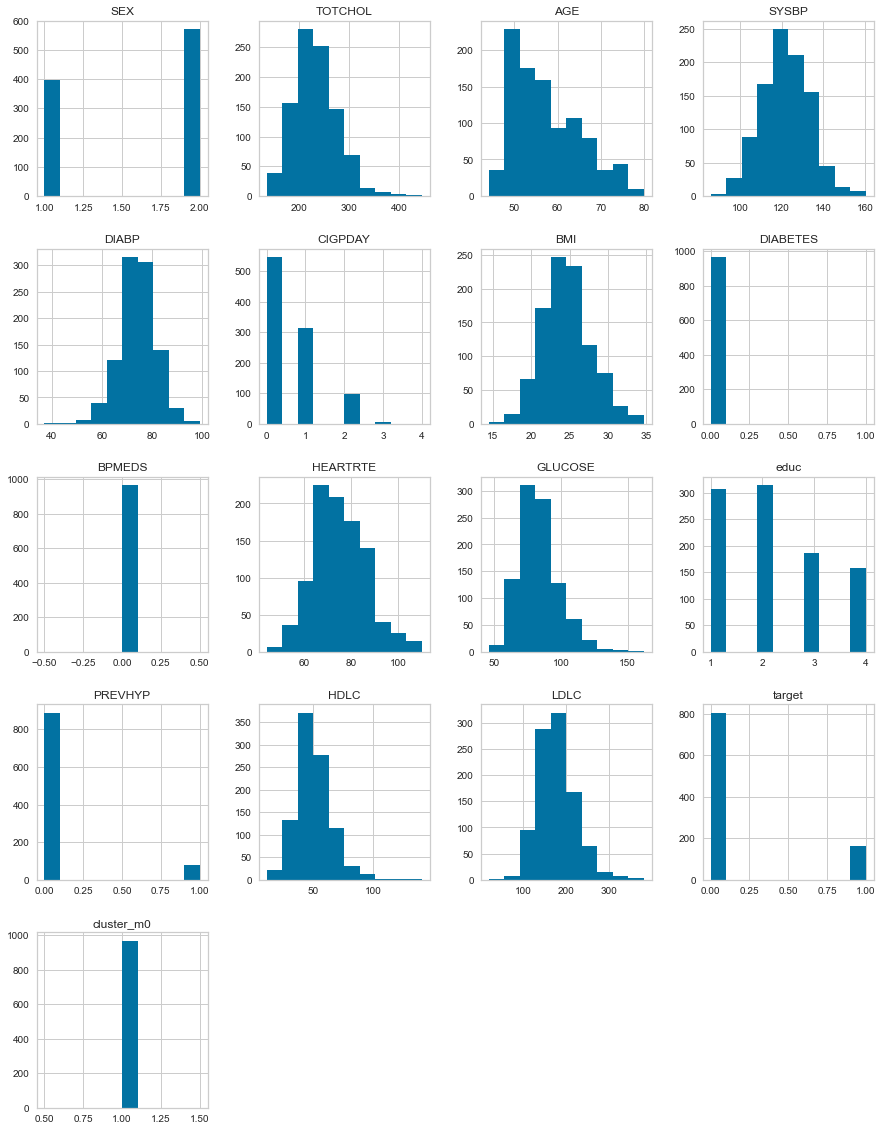

In [131]:
%matplotlib inline
G2=data_ul[data_ul['cluster_m0'] == 1].copy()
G2.describe()
G2.hist(figsize=(15,20))
plt.show()

#### Analyzing negative target on G2

In [132]:
G2_neg=G2[G2['target'] == 0].copy()
G2_neg.describe()

SEX     TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  804.000000  804.000000  804.000000  804.000000  804.000000  804.000000   
mean     1.628109  231.231343   56.835821  121.356965   74.172886    0.554726   
std      0.483610   42.772429    7.514231   11.477551    7.385698    0.700997   
min      1.000000  134.000000   44.000000   86.000000   46.000000    0.000000   
25%      1.000000  202.000000   51.000000  112.375000   69.875000    0.000000   
50%      2.000000  226.500000   55.000000  121.000000   74.250000    0.000000   
75%      2.000000  258.000000   62.000000  130.000000   80.000000    1.000000   
max      2.000000  413.000000   80.000000  160.500000   99.000000    3.000000   

              BMI    DIABETES  BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  804.000000  804.000000   804.0  804.000000  804.000000  804.000000   
mean    24.561070    0.001244     0.0   75.196517   83.583333    2.227612   
std      3.237443    0.035267     0.0   11.557585   15.017525    1.051209   
min     14.430000    0.000000     0.0   44.000000   46.000000    1.000000   
25%     22.350000    0.000000     0.0   68.000000   74.000000    1.000000   
50%     24.300000    0.000000     0.0   75.000000   81.000000    2.000000   
75%     26.390000    0.000000     0.0   82.000000   90.000000    3.000000   
max     34.690000    1.000000     0.0  110.000000  162.000000    4.000000   

          PREVHYP        HDLC        LDLC  target  cluster_m0  
count  804.000000  804.000000  804.000000   804.0       804.0  
mean     0.064677   50.222637  176.262438     0.0         1.0  
std      0.246107   14.439600   44.064535     0.0         0.0  
min      0.000000   11.000000   20.000000     0.0         1.0  
25%      0.000000   40.000000  144.750000     0.0         1.0  
50%      0.000000   49.000000  172.000000     0.0         1.0  
75%      0.000000   58.000000  202.000000     0.0         1.0  
max      1.000000  141.000000  376.000000     0.0         1.0

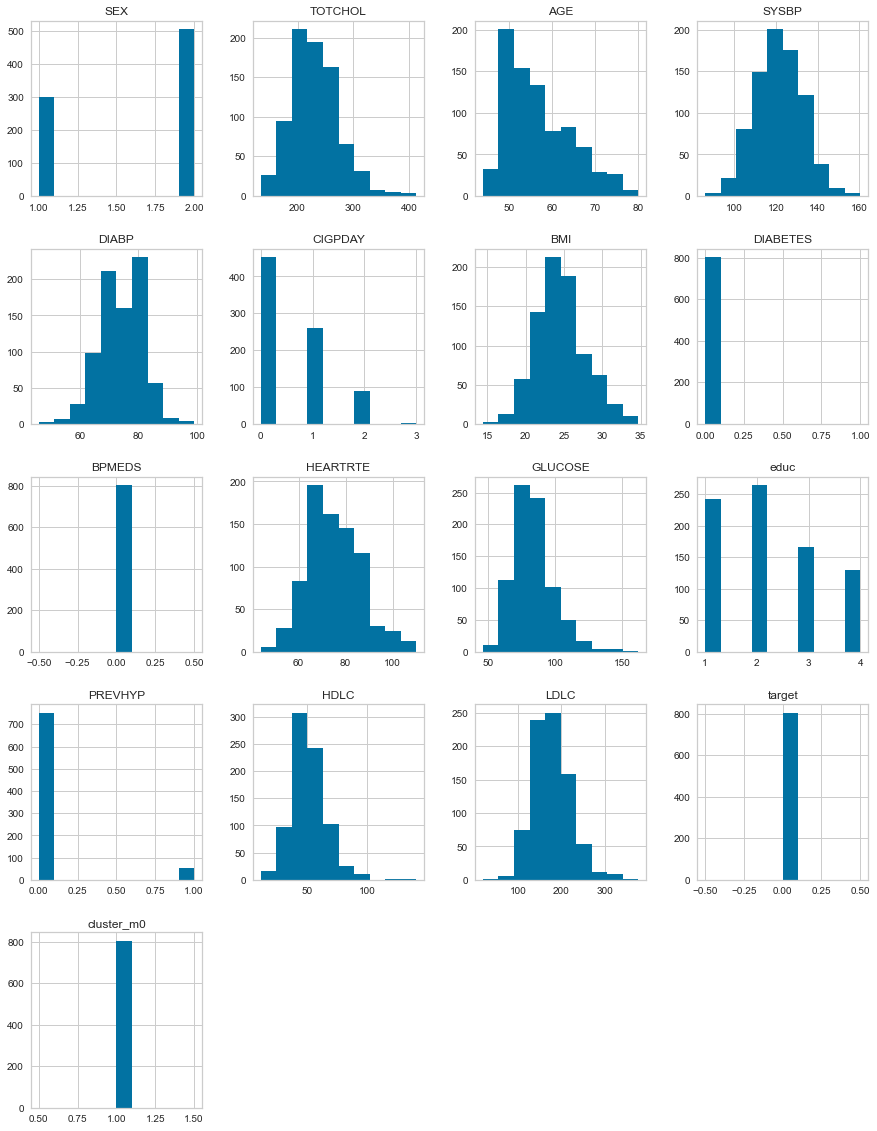

In [133]:
G2_neg.hist(figsize=(15,20))
plt.show()

#### Analyzing positive target on G2

In [134]:
G2_pos=G2[G2['target'] == 1].copy()
G2_pos.describe()

SEX     TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  164.000000  164.000000  164.000000  164.000000  164.000000  164.000000   
mean     1.408537  237.628049   60.256098  124.753049   74.015244    0.554878   
std      0.493069   43.254158    8.391218   11.578552    7.972234    0.769456   
min      1.000000  149.000000   47.000000   98.000000   37.000000    0.000000   
25%      1.000000  208.000000   53.000000  118.000000   70.000000    0.000000   
50%      1.000000  234.500000   59.000000  124.500000   74.000000    0.000000   
75%      2.000000  261.250000   67.000000  133.000000   80.000000    1.000000   
max      2.000000  446.000000   78.000000  160.500000   90.000000    4.000000   

              BMI  DIABETES  BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  164.000000     164.0   164.0  164.000000  164.000000  164.000000   
mean    24.914085       0.0     0.0   75.347561   84.475610    2.073171   
std      3.104925       0.0     0.0   10.777501   15.693948    1.099699   
min     15.160000       0.0     0.0   50.000000   49.000000    1.000000   
25%     22.702500       0.0     0.0   68.750000   73.000000    1.000000   
50%     24.995000       0.0     0.0   75.000000   81.000000    2.000000   
75%     26.800000       0.0     0.0   80.000000   94.000000    3.000000   
max     34.580000       0.0     0.0  110.000000  151.000000    4.000000   

          PREVHYP        HDLC        LDLC  target  cluster_m0  
count  164.000000  164.000000  164.000000   164.0       164.0  
mean     0.170732   46.798780  183.701220     1.0         1.0  
std      0.377427   16.359152   43.936259     0.0         0.0  
min      0.000000   12.000000   99.000000     1.0         1.0  
25%      0.000000   36.000000  154.500000     1.0         1.0  
50%      0.000000   43.500000  180.000000     1.0         1.0  
75%      0.000000   53.000000  206.250000     1.0         1.0  
max      1.000000  108.000000  381.000000     1.0         1.0

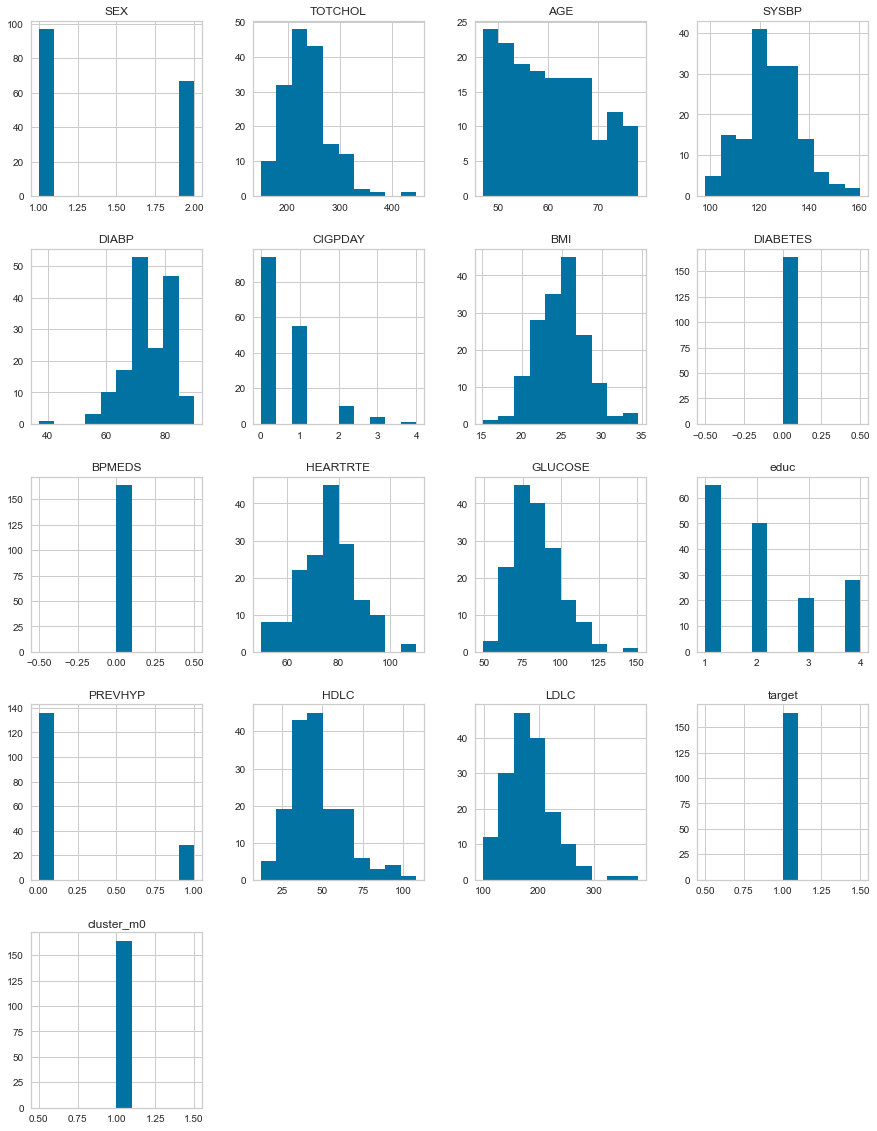

In [135]:
G2_pos.hist(figsize=(15,20))
plt.show()

#### Analyzing G3

In [136]:
%matplotlib inline
G3=data_ul[data_ul['cluster_m0'] == 2].copy()
G3.describe()

SEX     TOTCHOL         AGE       SYSBP       DIABP     CIGPDAY  \
count  157.000000  157.000000  157.000000  157.000000  157.000000  157.000000   
mean     1.464968  232.089172   62.942675  151.509554   82.802548    0.426752   
std      0.500367   49.298720    7.675504   26.192304   14.654981    0.681287   
min      1.000000  112.000000   48.000000   95.000000   30.000000    0.000000   
25%      1.000000  197.000000   57.000000  134.000000   71.000000    0.000000   
50%      1.000000  226.000000   64.000000  150.000000   82.000000    0.000000   
75%      2.000000  265.000000   70.000000  167.000000   91.000000    1.000000   
max      2.000000  462.000000   78.000000  246.000000  130.000000    3.000000   

              BMI  DIABETES      BPMEDS    HEARTRTE     GLUCOSE        educ  \
count  157.000000     157.0  157.000000  157.000000  157.000000  157.000000   
mean    27.044904       1.0    0.248408   82.292994  137.681529    2.063694   
std      4.585770       0.0    0.433472   13.942308   78.995134    1.130473   
min     16.360000       1.0    0.000000   50.000000   51.000000    1.000000   
25%     24.020000       1.0    0.000000   72.000000   85.000000    1.000000   
50%     26.200000       1.0    0.000000   82.000000  107.000000    2.000000   
75%     29.330000       1.0    0.000000   90.000000  173.000000    3.000000   
max     45.090000       1.0    1.000000  130.000000  478.000000    4.000000   

          PREVHYP        HDLC        LDLC      target  cluster_m0  
count  157.000000  157.000000  157.000000  157.000000       157.0  
mean     0.796178   45.382166  177.146497    0.484076         2.0  
std      0.404127   16.826237   50.045468    0.501346         0.0  
min      0.000000   15.000000   71.000000    0.000000         2.0  
25%      1.000000   34.000000  144.000000    0.000000         2.0  
50%      1.000000   43.000000  171.000000    0.000000         2.0  
75%      1.000000   52.000000  208.000000    1.000000         2.0  
max      1.000000  118.000000  428.000000    1.000000         2.0

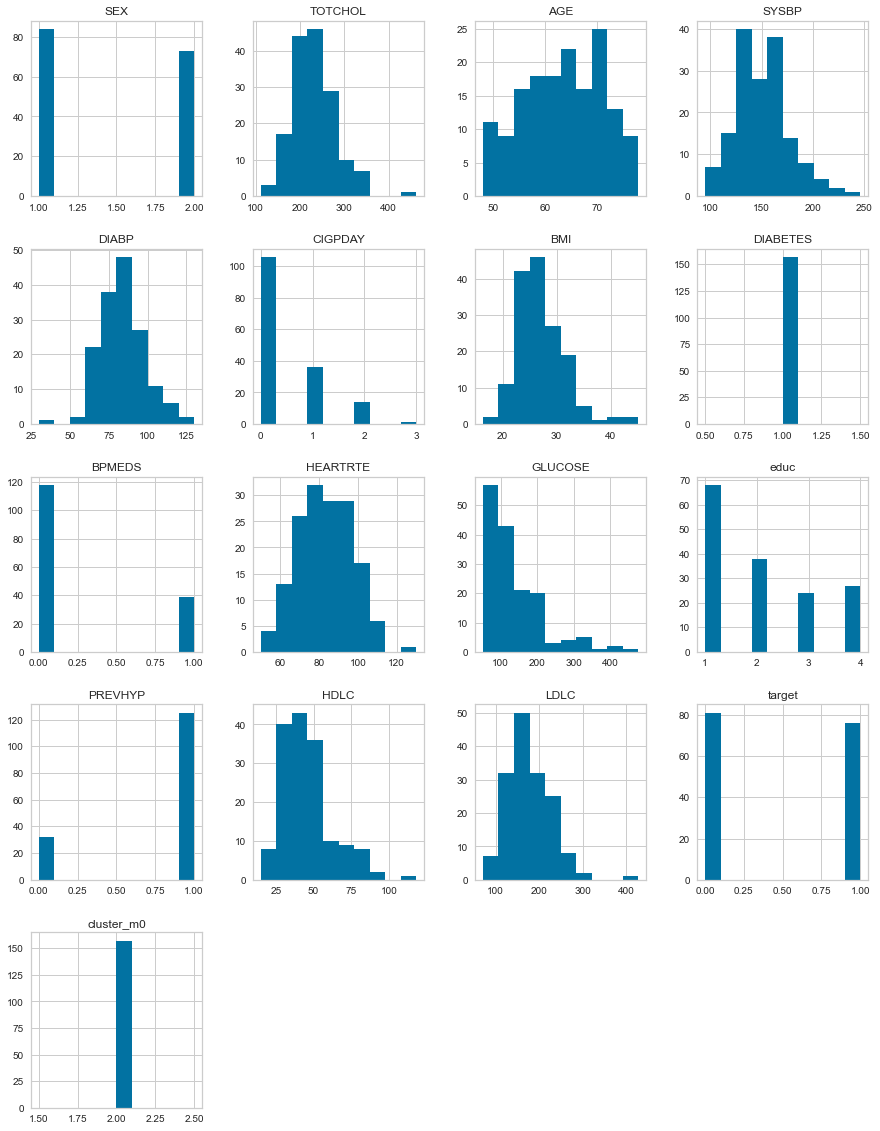

In [137]:
G3.hist(figsize=(15,20))
plt.show()

#### Analyzing positive target on G3

In [138]:
G3_pos=G3[G3['target'] == 1].copy()
G3_pos.describe()

SEX     TOTCHOL        AGE       SYSBP       DIABP    CIGPDAY  \
count  76.000000   76.000000  76.000000   76.000000   76.000000  76.000000   
mean    1.407895  238.828947  64.078947  152.144737   81.111842   0.473684   
std     0.494709   48.183645   7.317127   27.079982   15.957360   0.720624   
min     1.000000  141.000000  49.000000   95.000000   30.000000   0.000000   
25%     1.000000  208.000000  57.750000  134.250000   69.750000   0.000000   
50%     1.000000  237.500000  65.000000  150.000000   78.500000   0.000000   
75%     2.000000  271.750000  70.000000  168.250000   93.000000   1.000000   
max     2.000000  350.000000  78.000000  246.000000  119.000000   3.000000   

             BMI  DIABETES     BPMEDS    HEARTRTE     GLUCOSE       educ  \
count  76.000000      76.0  76.000000   76.000000   76.000000  76.000000   
mean   27.038289       1.0   0.276316   82.315789  143.486842   1.921053   
std     4.629290       0.0   0.450146   14.770430   92.142859   1.116699   
min    16.360000       1.0   0.000000   50.000000   51.000000   1.000000   
25%    24.020000       1.0   0.000000   73.500000   85.000000   1.000000   
50%    26.300000       1.0   0.000000   83.000000  102.500000   1.500000   
75%    29.672500       1.0   1.000000   92.500000  181.250000   3.000000   
max    42.470000       1.0   1.000000  130.000000  478.000000   4.000000   

         PREVHYP        HDLC        LDLC  target  cluster_m0  
count  76.000000   76.000000   76.000000    76.0        76.0  
mean    0.868421   42.657895  183.986842     1.0         2.0  
std     0.340279   16.838490   46.989217     0.0         0.0  
min     0.000000   17.000000   91.000000     1.0         2.0  
25%     1.000000   31.000000  150.250000     1.0         2.0  
50%     1.000000   39.000000  180.500000     1.0         2.0  
75%     1.000000   48.000000  216.500000     1.0         2.0  
max     1.000000  118.000000  296.000000     1.0         2.0

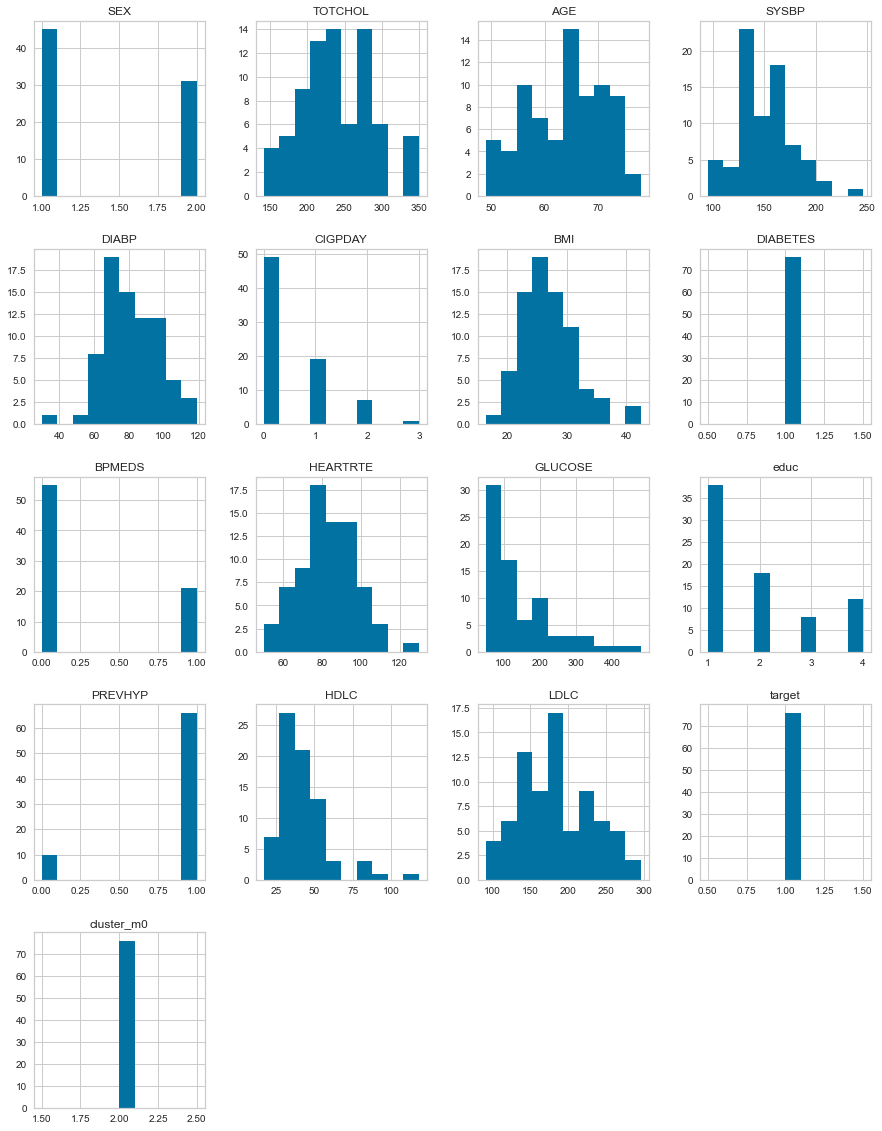

In [139]:
G3_pos.hist(figsize=(15,20))
plt.show()

#### Analyzing negative target on G3

In [140]:
G3_neg=G3[G3['target'] == 0].copy()
G3_neg.describe()

SEX     TOTCHOL        AGE      SYSBP       DIABP    CIGPDAY  \
count  81.000000   81.000000  81.000000   81.00000   81.000000  81.000000   
mean    1.518519  225.765432  61.876543  150.91358   84.388889   0.382716   
std     0.502770   49.789625   7.893641   25.48600   13.221668   0.643582   
min     1.000000  112.000000  48.000000  103.00000   59.000000   0.000000   
25%     1.000000  196.000000  55.000000  134.00000   75.000000   0.000000   
50%     2.000000  220.000000  62.000000  148.00000   83.000000   0.000000   
75%     2.000000  250.000000  69.000000  166.00000   90.000000   1.000000   
max     2.000000  462.000000  77.000000  225.00000  130.000000   2.000000   

             BMI  DIABETES     BPMEDS    HEARTRTE     GLUCOSE       educ  \
count  81.000000      81.0  81.000000   81.000000   81.000000  81.000000   
mean   27.051111       1.0   0.222222   82.271605  132.234568   2.197531   
std     4.573411       0.0   0.418330   13.210803   64.395122   1.133796   
min    18.810000       1.0   0.000000   57.000000   58.000000   1.000000   
25%    23.920000       1.0   0.000000   70.000000   86.000000   1.000000   
50%    26.150000       1.0   0.000000   82.000000  114.000000   2.000000   
75%    29.230000       1.0   0.000000   90.000000  164.000000   3.000000   
max    45.090000       1.0   1.000000  110.000000  423.000000   4.000000   

         PREVHYP       HDLC        LDLC  target  cluster_m0  
count  81.000000  81.000000   81.000000    81.0        81.0  
mean    0.728395  47.938272  170.728395     0.0         2.0  
std     0.447559  16.510864   52.227630     0.0         0.0  
min     0.000000  15.000000   71.000000     0.0         2.0  
25%     0.000000  34.000000  140.000000     0.0         2.0  
50%     1.000000  48.000000  162.000000     0.0         2.0  
75%     1.000000  58.000000  202.000000     0.0         2.0  
max     1.000000  91.000000  428.000000     0.0         2.0

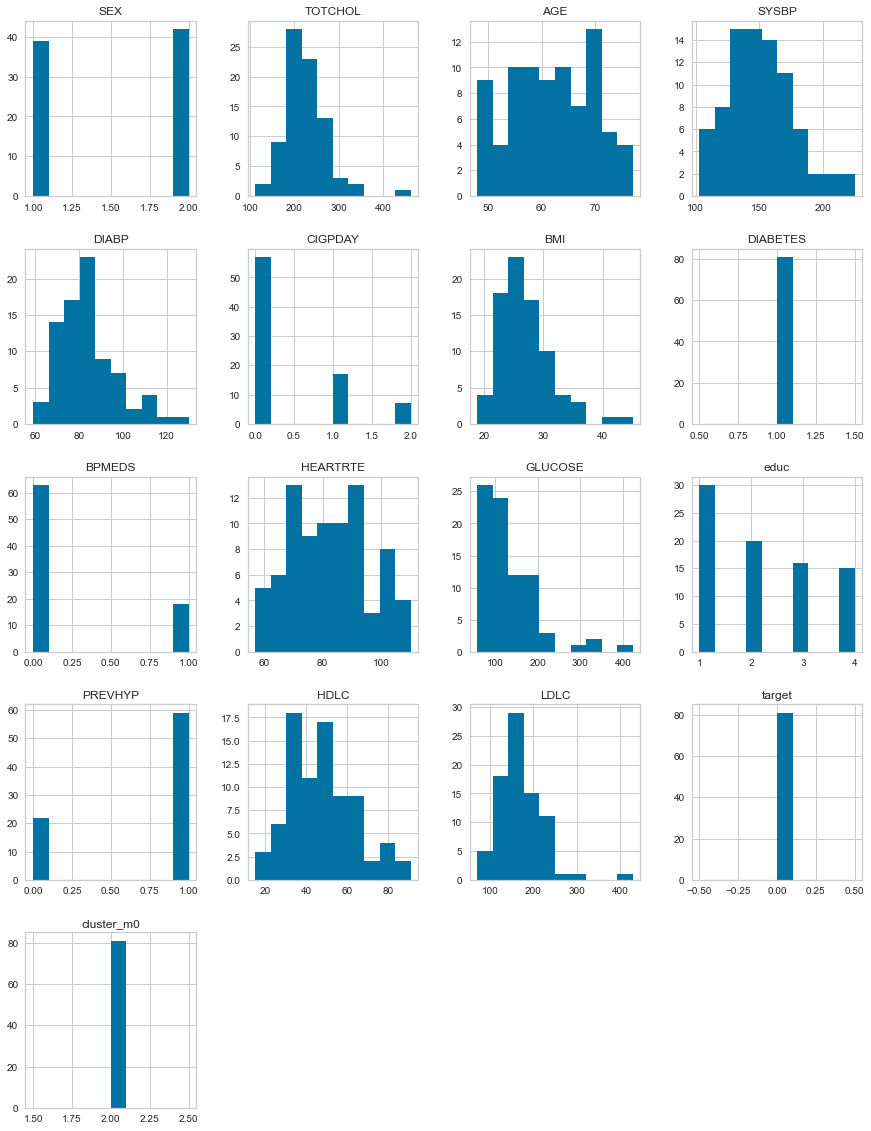

In [141]:
G3_neg.hist(figsize=(15,20))
plt.show()